# Phase 2

### Team members:
 - Andrej Milovanovikj
 - Marko Bogoevski
 - Oliver Cvetkovski
 - Andrej Nasteski
 - Gligor Atanasovski

In [5]:
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import os
import matplotlib.pyplot as plt
import random as rn
import scipy.io
from scipy.signal import savgol_filter, butter, lfilter, freqz
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model,layers,Sequential,regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger
import sklearn
%matplotlib inline

## Data aggregation

#### The code below represents a pipeline for data aggregation for the medicon dataset. The aggregation consists of aggregating the 3 available sessions for each subject separately. The pipeline receives as input a folder in which are located all datasets for each subject and as output creates a new folder with the aggregated data for each subject on session level. More precisely, it concatenates  the train data and test data for every session into single training and testing sets for each subject separately.

In [2]:
def make_directory_tree(tree, output_dir):
    """
    Create the output directory tree structure specified by `tree` in `output_dir`

    Parameters
    -----
    tree : list of paths to create under `output_dir`

    output_dir : path to root of output directory tree
    """

    for d in tree:
        try:
            path = os.path.join(output_dir, d)
            os.makedirs(path, exist_ok=True)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(path):
                print("Path already exists: {}".format(d))
                print("Files may be overwritten")
                continue
            else:
                raise


def combine_reports(files_to_combine, outpath, is_mat=False,is_train=True):
    """
    Produce a combined file from all the input files and saves it in outpath

    Parameters
    -----
    files_to_combine : data of same type

    outpath : path at which to save the combined dataset
    """
    
    if outpath.endswith(".txt"):
        outpath = outpath.replace(".txt",".csv")
        
    print("Creating file: ",outpath)
    
    if is_mat:
        if is_train:
            arrays = tuple([scipy.io.loadmat(file)['trainData'] for file in files_to_combine])
            merged_array = np.concatenate(arrays,axis=-1)
            matlab_dict = {'trainData':merged_array}
        else:
            arrays = tuple([scipy.io.loadmat(file)['testData'] for file in files_to_combine])
            merged_array = np.concatenate(arrays,axis=-1)
            matlab_dict = {'testData':merged_array}
            
        scipy.io.savemat(outpath,matlab_dict)
        
    else:
        dfs = [pd.read_csv(file,header=None) for file in files_to_combine]
        df = pd.concat(dfs,ignore_index=True)
        df.columns=['Values']
        df.to_csv(outpath,index=False)


def get_datasets(data_dir):
    """
    Get all filenames from the specified directory

    Parameters
    -----
    data_dir : path to directory containing the files

    Returns
    -----
    ret : list containing dataset filenames
    """

    return [f for f in os.listdir(data_dir) if os.path.isfile(
        os.path.join(data_dir, f)) and (f.endswith(".txt") or f.endswith(".mat"))]   


def run_data_aggregation(input_dir, output_dir):
    """
    Iterate over the input directories and generate the new aggregated files in the output_dir

    Parameters
    -----
    input_dir : path to directory containing input data
    
    output_dir : output directory for storing processed data

    """
    number_of_subjects=15
    subject_names = ["SBJ"+str(i).zfill(2) for i in range(1,number_of_subjects+1)]
    number_of_sessions = 3
    session_names = ["S"+str(i).zfill(2) for i in range(1,number_of_sessions+1)]
    train_files = get_datasets(os.path.join(input_dir,"SBJ01/S01/Train"))
    test_files = get_datasets(os.path.join(input_dir,"SBJ01/S01/Test"))
    
    #Creating folders for each subject
    make_directory_tree(subject_names,output_dir)
    for subject_no in range(number_of_subjects):
        trainEvents=[]
        trainLabels=[]
        trainTargets=[]
        trainData=[]
        testData=[]
        testEvents=[]
        testRunsPerBlock=[]
        subject_output_folder = os.path.join(output_dir,subject_names[subject_no])
        print("Currently processing : ",subject_output_folder)
        #Making train and test folders for each subject
        make_directory_tree(['Train','Test'],subject_output_folder)
        subject_input_folder = os.path.join(input_dir,subject_names[subject_no])
        for session_no in range(number_of_sessions):
            input_session_folder = os.path.join(subject_input_folder,session_names[session_no])
            train_folder = os.path.join(input_session_folder,"Train")
            test_folder = os.path.join(input_session_folder,"Test")
            train_paths = [os.path.join(train_folder,train_file) for train_file in train_files]
            test_paths = [os.path.join(test_folder,test_file) for test_file in test_files]

            trainData.append(train_paths[0])
            trainEvents.append(train_paths[1])
            trainLabels.append(train_paths[2])
            trainTargets.append(train_paths[3])
            
            testRunsPerBlock.append(test_paths[0])
            testData.append(test_paths[1])
            testEvents.append(test_paths[2])
            
        train_output_folder = os.path.join(subject_output_folder,"Train")
        test_output_folder = os.path.join(subject_output_folder,"Test")
        
        combine_reports(trainData,os.path.join(train_output_folder,train_files[0]),is_mat=True)
        combine_reports(trainEvents,os.path.join(train_output_folder,train_files[1]))
        combine_reports(trainLabels,os.path.join(train_output_folder,train_files[2]))
        combine_reports(trainTargets,os.path.join(train_output_folder,train_files[3]))
        
        combine_reports(testRunsPerBlock,os.path.join(test_output_folder,test_files[0]),is_train=False)
        combine_reports(testData,os.path.join(test_output_folder,test_files[1]),is_mat=True,is_train=False)
        combine_reports(testEvents,os.path.join(test_output_folder,test_files[2]),is_train=False)

#### Data should be organized in the next way for the pipeline to work: In the folder where the notebook exists, there should be a folder named medicon data and inside the folder another one named subjects_pre where the data for all the subjects should reside as folders: SBJ01...SBJ15 (same as download names). The pipeline will then create a new folder subjects_post in the medicon data folder containing the merged data for all sessions for each subject, meaning after the data aggregation we won't have separate session folders for each subject, instead they will be aggregated together into a single one

In [3]:
# Running the data aggregation pipeline
run_data_aggregation("medicon_data/subjects_pre", "medicon_data/subjects_post")

Currently processing :  medicon_data/subjects_post\SBJ01
Creating file:  medicon_data/subjects_post\SBJ01\Train\trainData.mat
Creating file:  medicon_data/subjects_post\SBJ01\Train\trainEvents.csv
Creating file:  medicon_data/subjects_post\SBJ01\Train\trainLabels.csv
Creating file:  medicon_data/subjects_post\SBJ01\Train\trainTargets.csv
Creating file:  medicon_data/subjects_post\SBJ01\Test\runs_per_block.csv
Creating file:  medicon_data/subjects_post\SBJ01\Test\testData.mat
Creating file:  medicon_data/subjects_post\SBJ01\Test\testEvents.csv
Currently processing :  medicon_data/subjects_post\SBJ02
Creating file:  medicon_data/subjects_post\SBJ02\Train\trainData.mat
Creating file:  medicon_data/subjects_post\SBJ02\Train\trainEvents.csv
Creating file:  medicon_data/subjects_post\SBJ02\Train\trainLabels.csv
Creating file:  medicon_data/subjects_post\SBJ02\Train\trainTargets.csv
Creating file:  medicon_data/subjects_post\SBJ02\Test\runs_per_block.csv
Creating file:  medicon_data/subjects_

In [4]:
#Testing mat train file (1 session vs all 3 sessions shapes). New files should be 3 times the size:
old_train_folder = "medicon_data/subjects_pre/SBJ02/S01/Train"

mat = scipy.io.loadmat(os.path.join(old_train_folder,"trainData"))
data = mat['trainData']
print("Old mat train file shape: ",data.shape)

train_events = pd.read_csv(os.path.join(old_train_folder,"trainEvents.txt"),header=None)
print("Old train events shape: ",train_events.shape)

train_labels = pd.read_csv(os.path.join(old_train_folder,"trainLabels.txt"),header=None)
print("Old train labels shape: ",train_labels.shape)

train_targets = pd.read_csv(os.path.join(old_train_folder,"trainTargets.txt"),header=None)
print("Old train targets shape: ",train_targets.shape)

new_train_folder = "medicon_data/subjects_post/SBJ02/Train"

mat = scipy.io.loadmat(os.path.join(new_train_folder,"trainData"))
data = mat['trainData']
print("New mat train file shape: ",data.shape)

train_events = pd.read_csv(os.path.join(new_train_folder,"trainEvents.csv"))
print("New train events shape: ",train_events.shape)

train_labels = pd.read_csv(os.path.join(new_train_folder,"trainLabels.csv"))
print("New train labels shape: ",train_labels.shape)

train_targets = pd.read_csv(os.path.join(new_train_folder,"trainTargets.csv"))
print("New train targets shape: ",train_targets.shape)

Old mat train file shape:  (8, 350, 1600)
Old train events shape:  (1600, 1)
Old train labels shape:  (20, 1)
Old train targets shape:  (1600, 1)
New mat train file shape:  (8, 350, 4800)
New train events shape:  (4800, 1)
New train labels shape:  (60, 1)
New train targets shape:  (4800, 1)


#### We see that the pipeline works as expected. It creates a new folder for a subject where the train folders and test folders now hold data for each of the 3 sessions together concatenated temporaly.

#### Now we visualize the EEG signal collected from each sensor for SBJ01 in the first run of his/hers first session. The event with orange colored plot lines is the target event.

In [18]:
channels = ['C3', 'Cz', 'C4', 'CPz', 'P3', 'Pz', 'P4', 'POz']

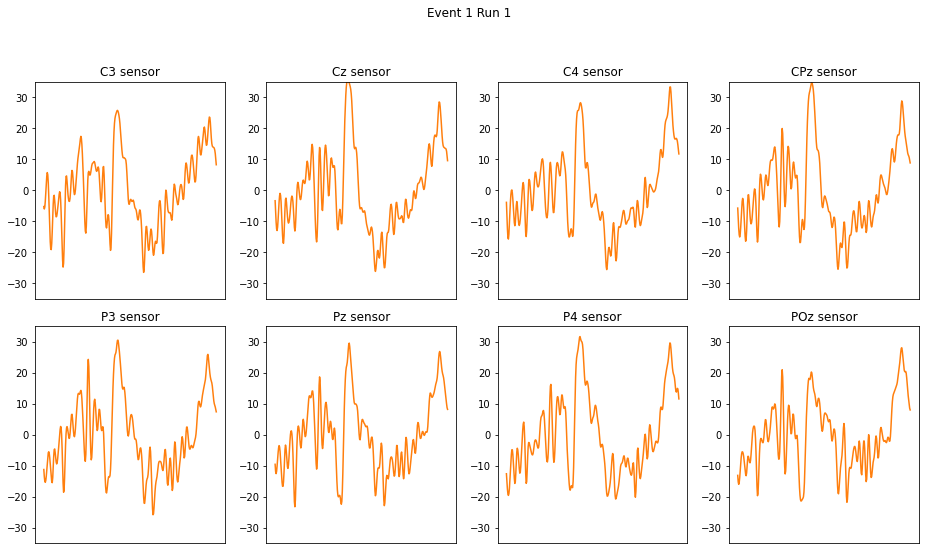

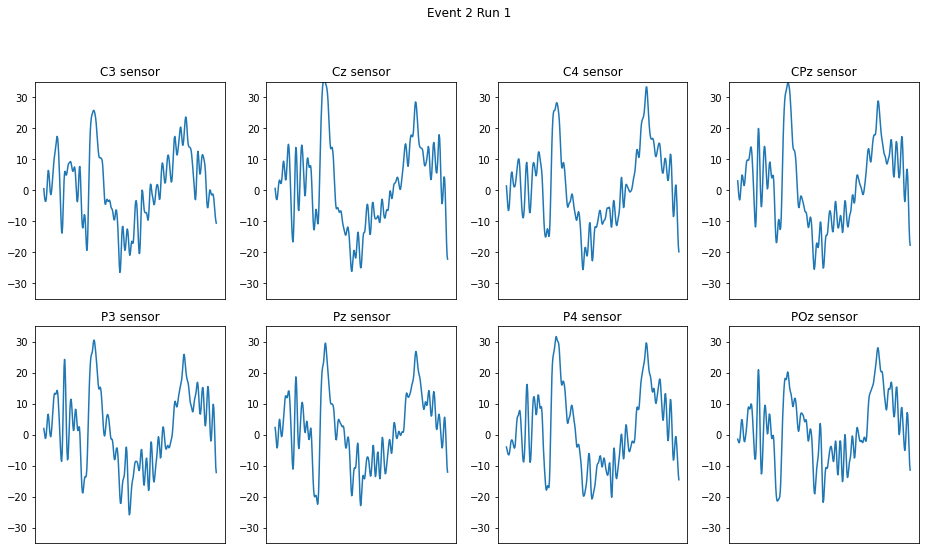

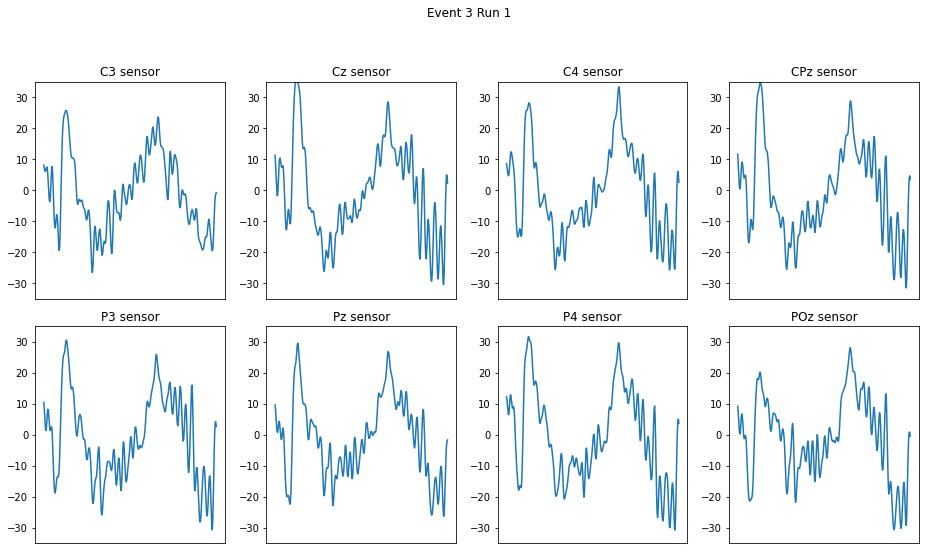

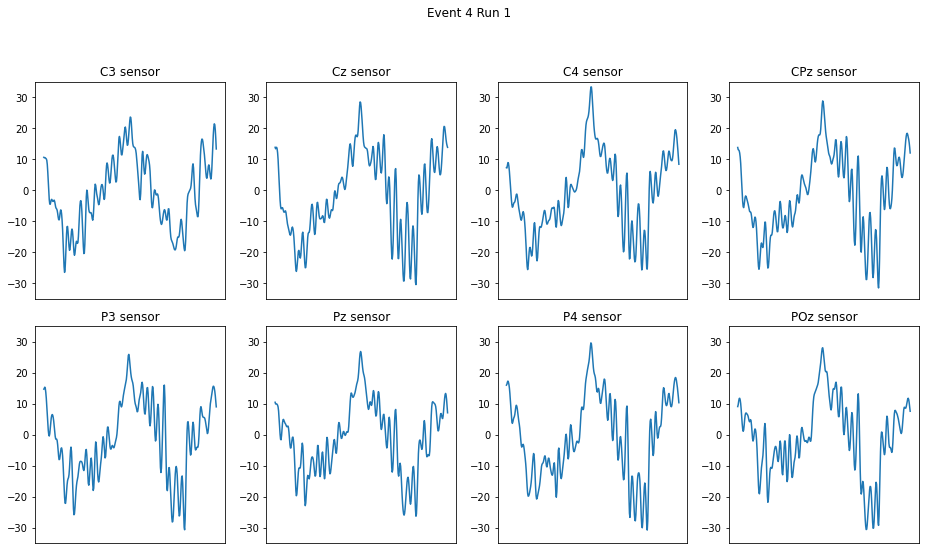

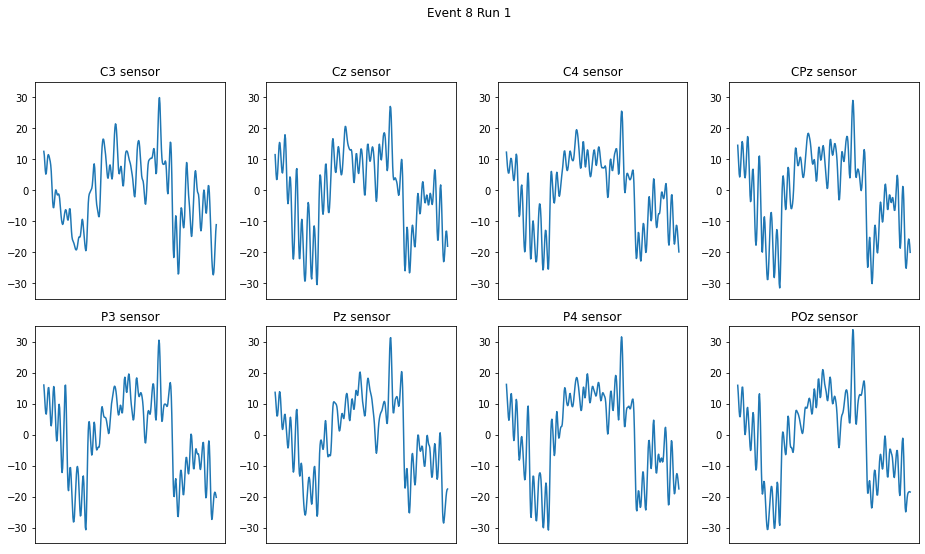

In [19]:
for i in range(8):
    fig = plt.figure(figsize=(13,8))
    fig.subplots(2,4)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle("Event " + str(i+1) + " Run 1")
    for j in range(8):
        ax = plt.subplot(2,4,j+1)
        ax.set_ylim([-35,35])  
        plt.xticks([])
        plt.title(channels[j] + " sensor")
        if train_targets.iloc[i].item() == 1:
            plt.plot(range(350),data[j,:,i], 'C1') #sensor;signal;run
        else:
            plt.plot(range(350),data[j,:,i])
    plt.show()

#### Next, lets compute the mean value of the signal for each sensor (for SBJ02), first for every session, in order to see the difference in the data between sessions

In [20]:
for i in range(3):
    fig = plt.figure(figsize=(13,8))
    fig.subplots(2,4)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle("Session " + str(i+1))
    for j in range(8):
        ax = plt.subplot(2,4,j+1)
        plt.xticks([])
        ax.set_ylim([-1,1])
        start_session = i*1600
        end_session = start_session + 1600
        plt.title(channels[j] + " sensor")
        plt.plot(range(350),data[j,:,start_session:end_session].mean(axis=1))
    plt.show()

#### We can clearly see that the means for each sessions are very inconsistent, which could indicate that the signal varies a lot between sessions, but could also imply that the mean is not a rapresentative statistic, hence no valuable information for the raw signal can be extracted from it.
#### Next, let's try the Savitzky–Golay filter.

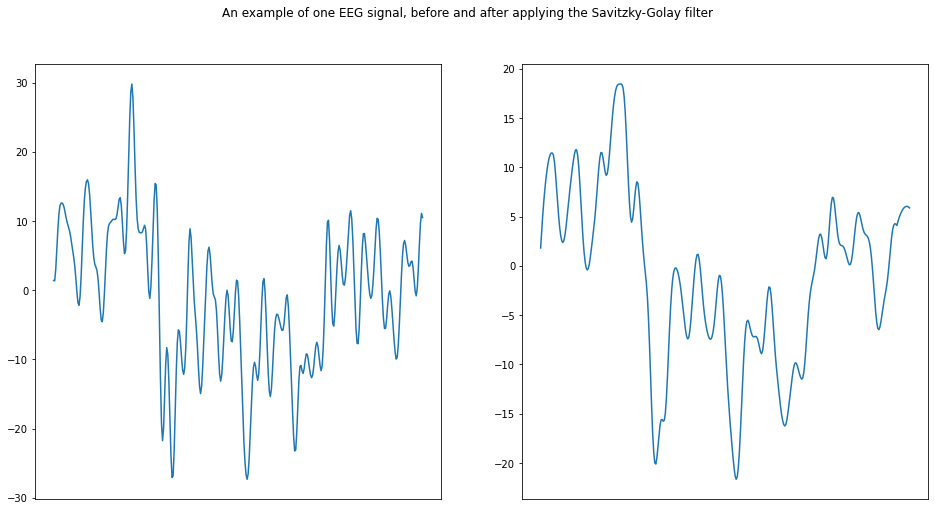

In [31]:
sg_data = savgol_filter(data,25,2,axis=1) 
fig = plt.figure(figsize=(16,8))
fig.subplots(1,2)
fig.suptitle("An example of one EEG signal, before and after applying the Savitzky-Golay filter")
ax = plt.subplot(121)
plt.plot(range(350),data[0,:,10])
plt.xticks([])
ax = plt.subplot(122)
plt.plot(range(350),sg_data[0,:,10])
plt.xticks([])
plt.show()

This filter is used in order to smoothen out the signal, and hopefully remove some of the noise (since EEG signals have high signal-to-noise ratio). The parameters here are chosen wrt [Application of adaptive Savitzky—Golayfilter for EEG signal processing, Deepshikha Acharya et al.](https://www.sciencedirect.com/science/article/pii/S2213020916301951), but should later be tested for applicability and cross validated.

#### Further, we will visualize all 8 channels for a target event (in which the object of focus was the one that flashed). Alongside the signal, there are 2 temporal indicators:
1. The moment when the object flashes (orange dotted vertical line)
2. The interval in which the P300 positive spike is expected (green colored part)

In [37]:
fig = plt.figure(figsize=(13,26)) 
fig.subplots(4,2)
plt.tight_layout()
plt.subplots_adjust(top=0.975)
for j in range(8):
    ax = plt.subplot(4,2,j+1)
    ax.set_ylim([-35,35])
    plt.xticks([])
    plt.title(channels[j] + " sensor")
    plt.axvline(50, c='C1', ls='--')
    plt.axvspan(112.5, 175, facecolor='C2', alpha=0.3)    
    plt.plot(range(350),data[j,:,4])
plt.show()

#### The data is clearly too noisy to determine if there was or was not a spike in the targeted interval, so let's try out the previously mentioned filter and visualize again

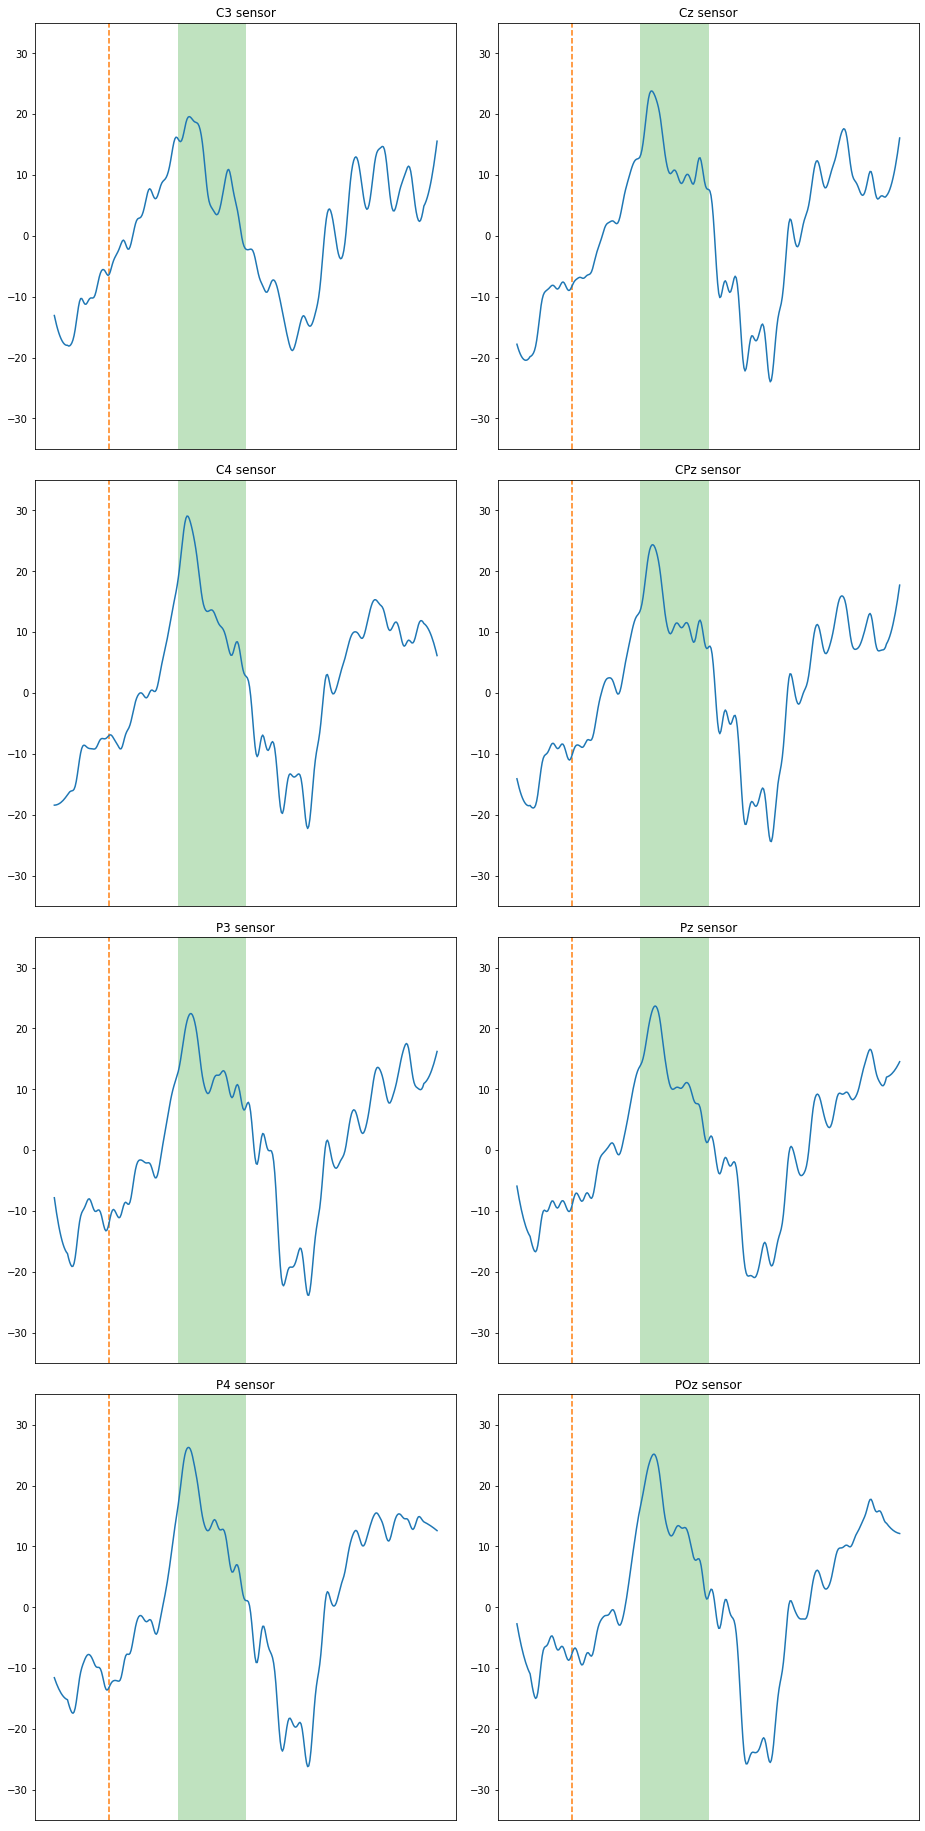

In [35]:
fig = plt.figure(figsize=(13,26))
fig.subplots(4,2)
plt.tight_layout()
plt.subplots_adjust(top=0.975)
for j in range(8):
    ax = plt.subplot(4,2,j+1)
    ax.set_ylim([-35,35])
    plt.xticks([])
    plt.title(channels[j] + " sensor")
    plt.axvline(50, c='C1', ls='--')
    plt.axvspan(112.5, 175, facecolor='C2', alpha=0.3)    
    plt.plot(range(350),sg_data[j,:,4])
plt.show()

#### The difference, when compared to the non-filtered visualization, is apparent and from this imaging we can notice that not all channels get a radical spike in the targeted interval, so let us visualize a target event alongside a non-target event and try to notice any changes in the interval.

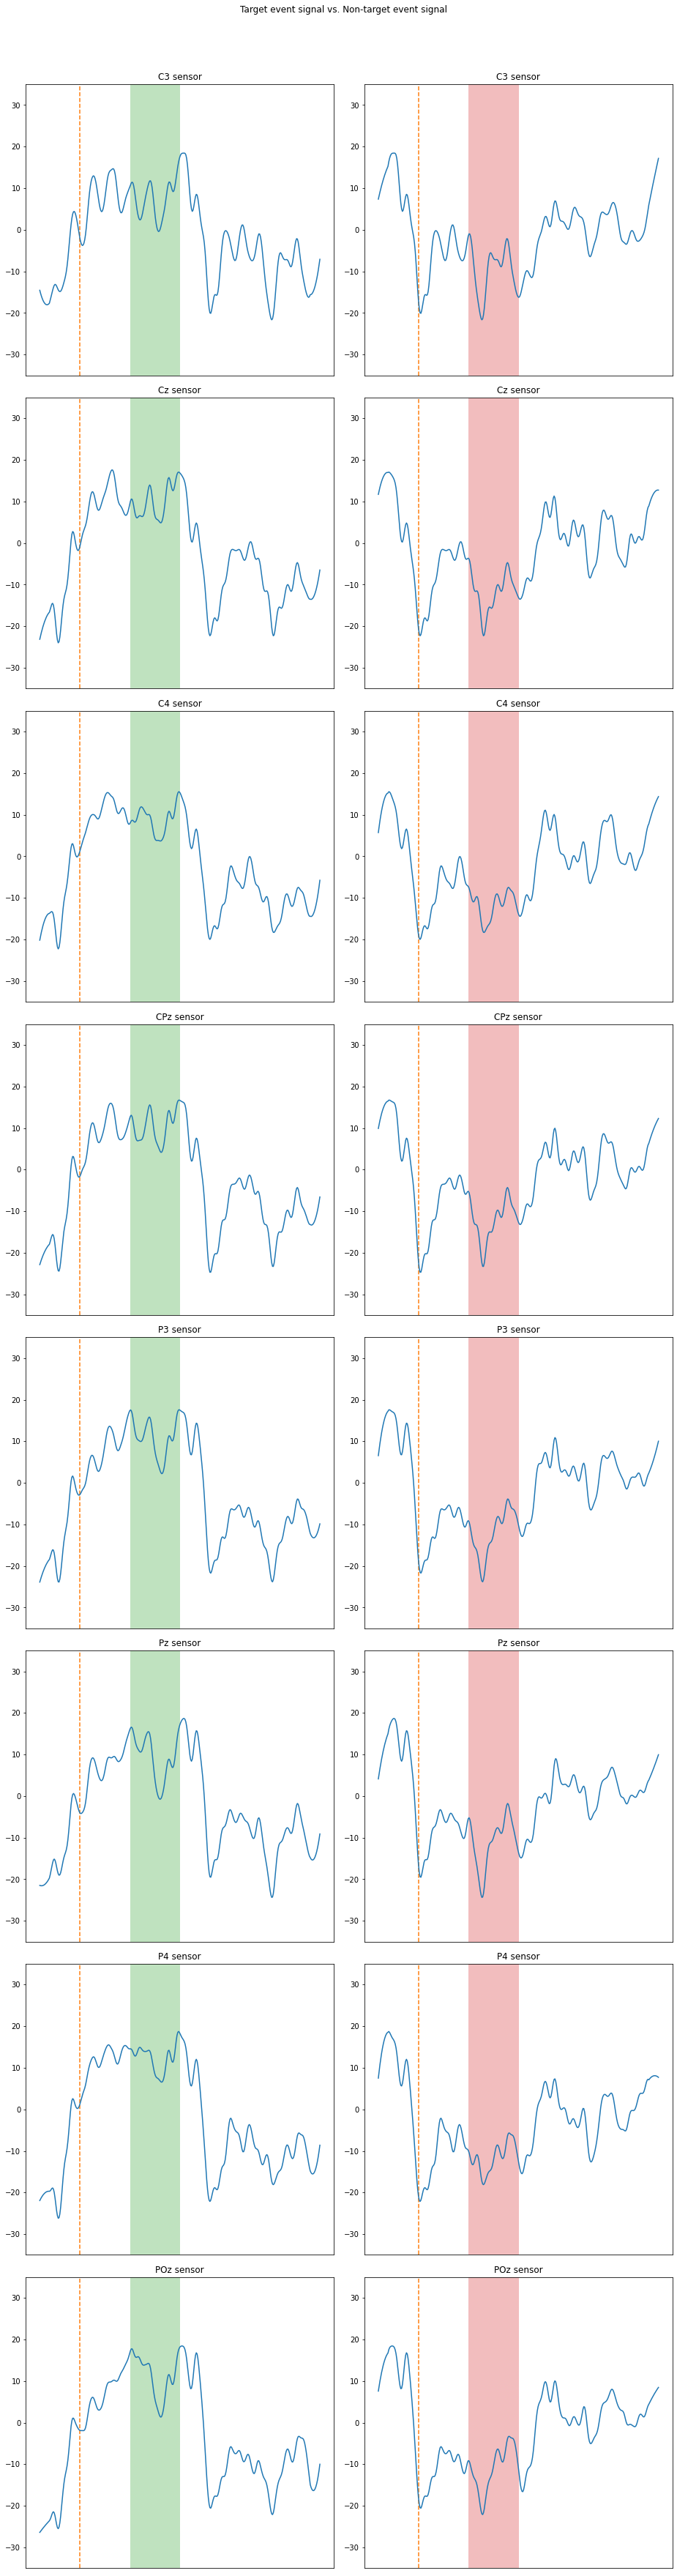

In [43]:
fig = plt.figure(figsize=(13,50))
fig.subplots(8,2)
fig.suptitle("Target event signal vs. Non-target event signal")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
for j in range(8):
    ax = plt.subplot(8,2,2*j+1)
    ax.set_ylim([-35,35])
    plt.xticks([])
    plt.title(channels[j] + " sensor")
    plt.axvline(50, c='C1', ls='--')
    plt.axvspan(112.5, 175, facecolor='C2', alpha=0.3)    
    plt.plot(range(350),sg_data[j,:,8])
    
    ax = plt.subplot(8,2,2*j+2)
    ax.set_ylim([-35,35])
    plt.xticks([])
    plt.title(channels[j] + " sensor")
    plt.axvline(50, c='C1', ls='--')
    plt.axvspan(112.5, 175, facecolor='C3', alpha=0.3)    
    plt.plot(range(350),sg_data[j,:,11])
plt.show()

#### With this last plot, we can see some differences in the plots for the target and non-target signal. On some of the channels we seem to have drastcly different signals, but on others the signal looks the same, only it's shifted in one direction or the other (on the x-axis of course). This may be an indicator that we should try to rank the channels in order of importance (maybe using a DBN as we suggested in phase 1).

#### Let's draw all channels on one plot for one whole run. This is SBJ02, Session1, Block1, Run4

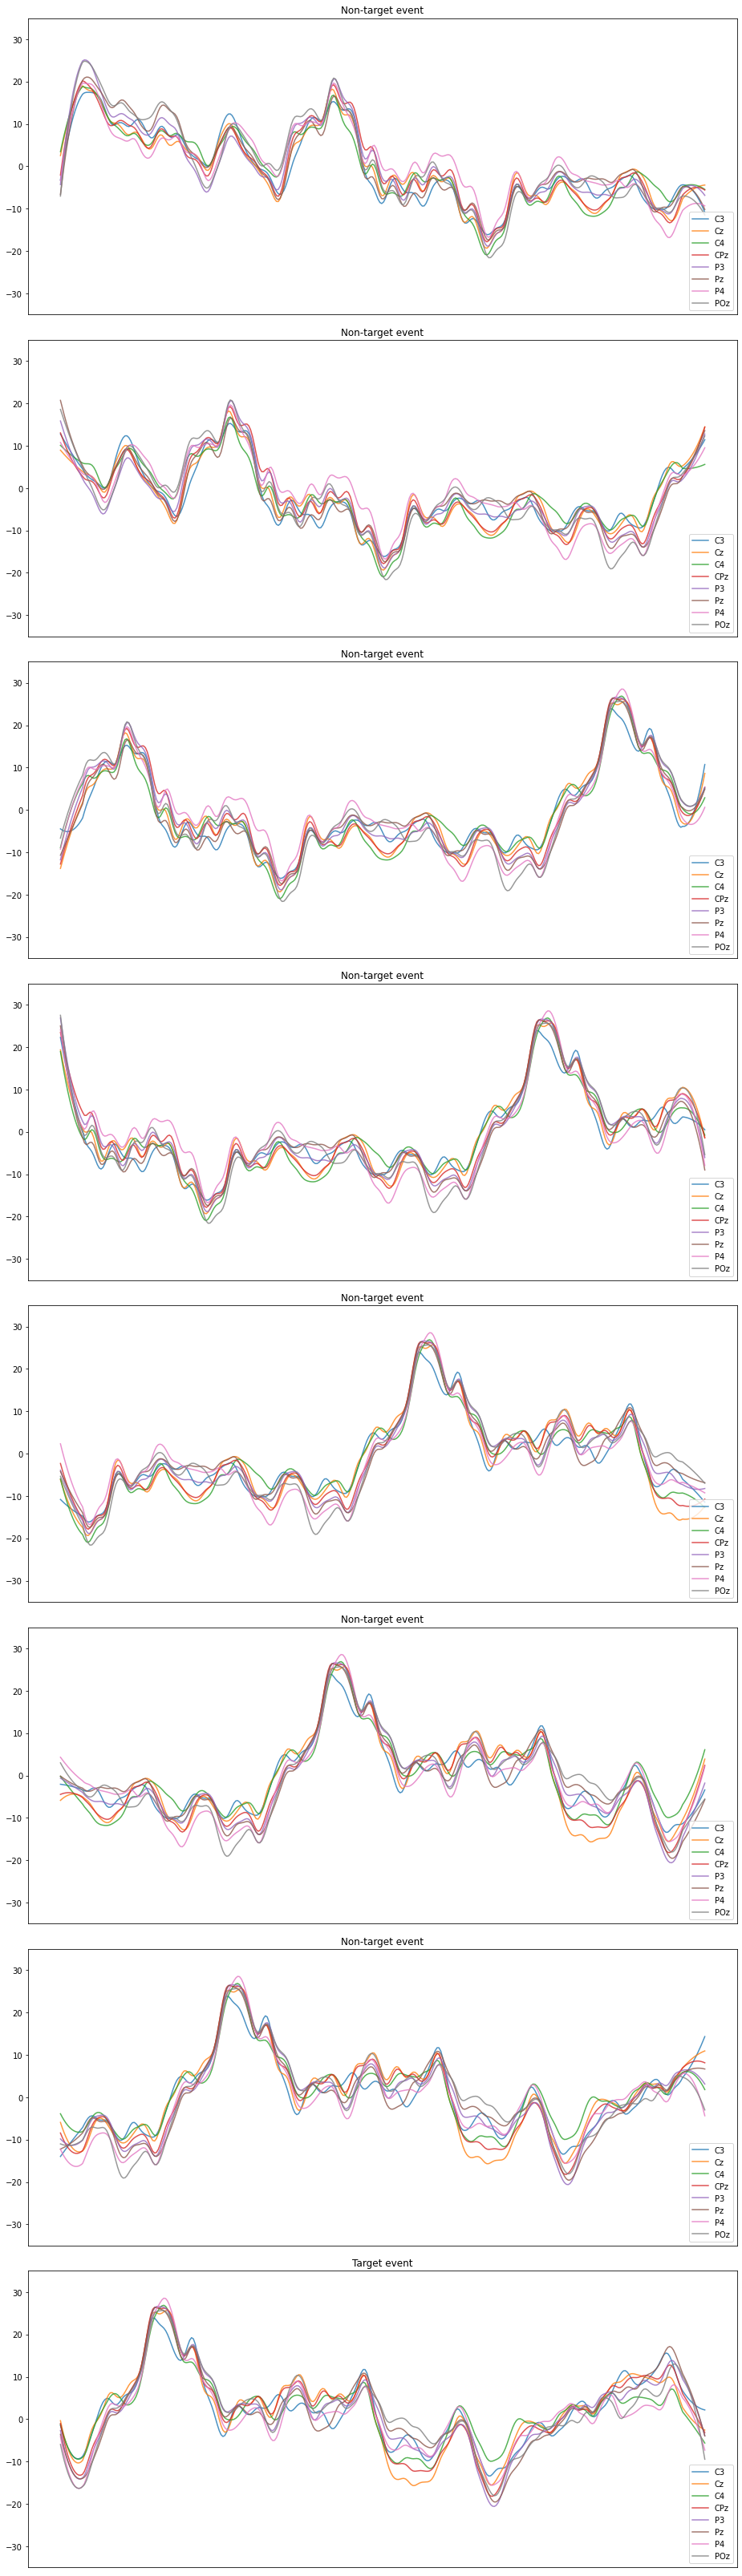

In [45]:
fig = plt.figure(figsize=(13,45))
fig.subplots(8,1)
plt.tight_layout()
plt.subplots_adjust(top=0.99)
for i in range(24,32):
    ax = plt.subplot(8,1,i-23)
    ax.set_ylim([-35,35])
    plt.xticks([])
    if train_targets.iloc[i].item() == 1:
        plt.title("Target event")
    else:
        plt.title("Non-target event")
    for j in range(8):
        plt.plot(range(350),sg_data[j,:,i], label=channels[j], alpha=.8)
    plt.legend(loc='lower right')
plt.show()

#### From this last visualization we can see that the channels vary from one another to some degree, but more importantly, we see that some non-target events have bigger spikes than a target event, which is an indicator that we will have to be careful in the preprocessing and model creation. Adding a prior in the interval where P300 is expected seemed a good idea from the last few plots, but from this specific run we see that we might have to think twice before making that decision.

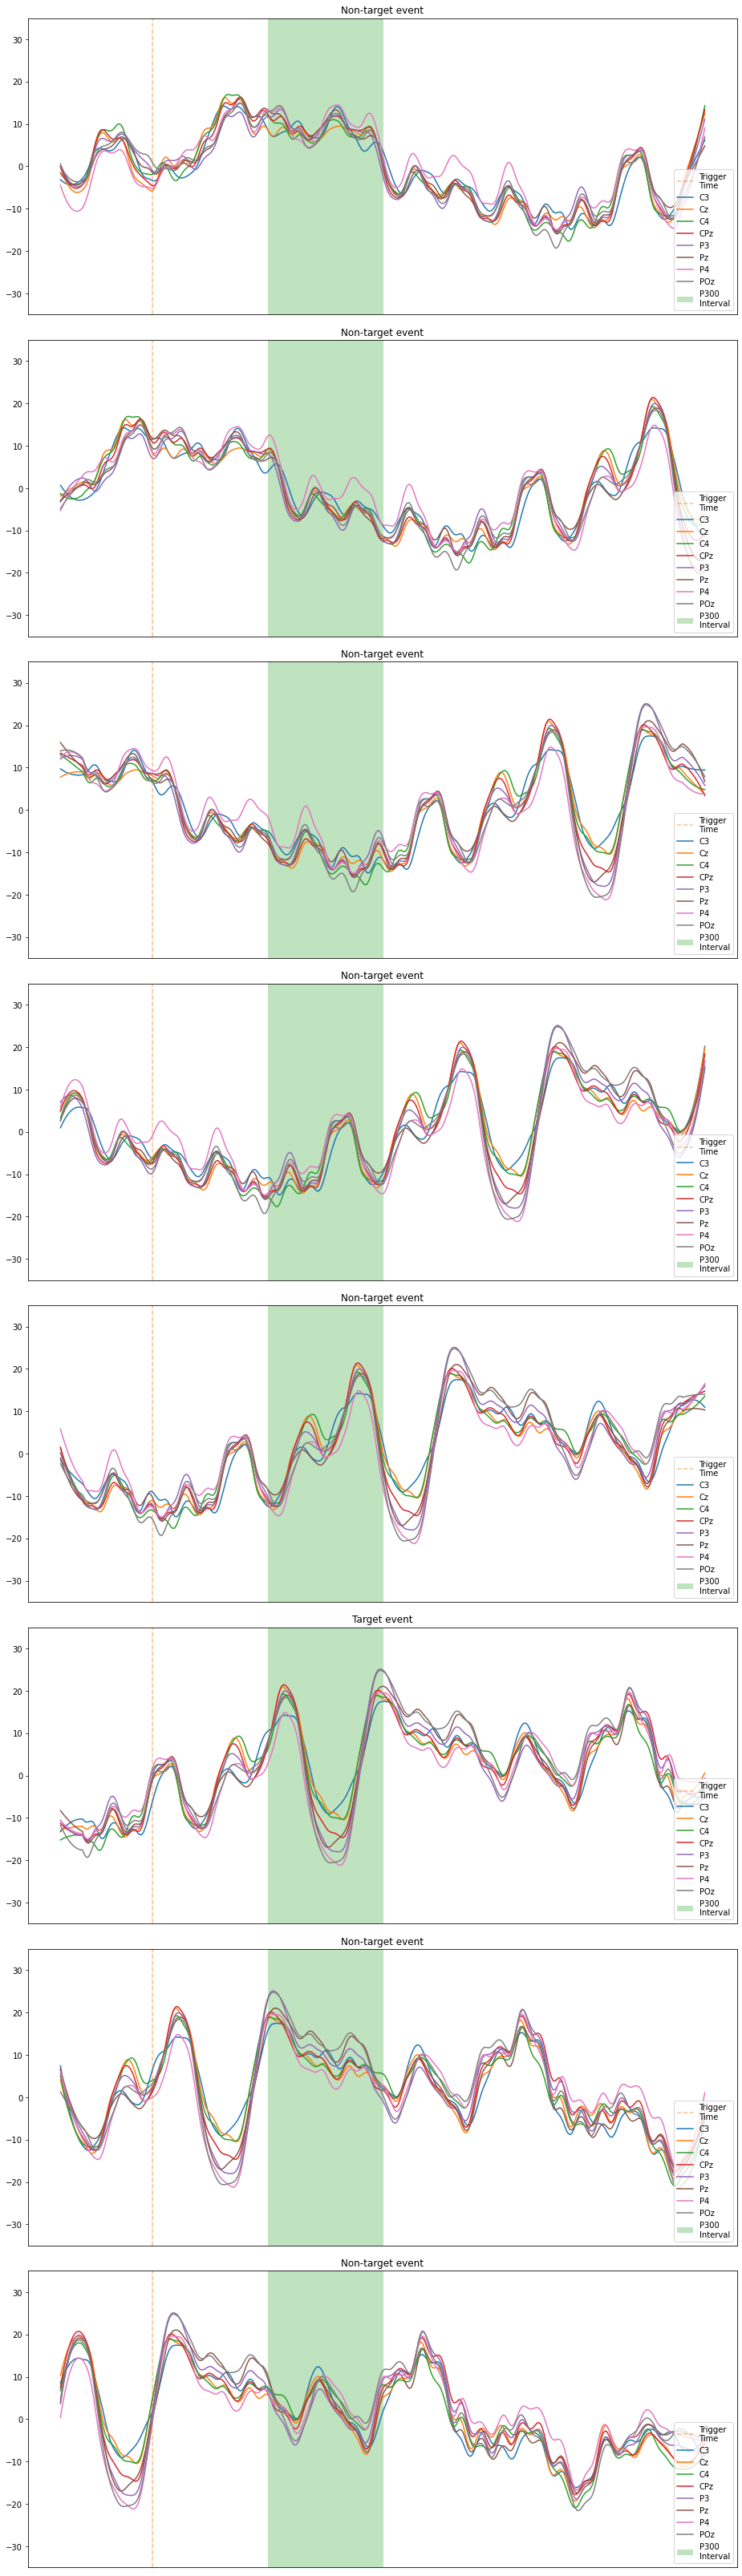

In [48]:
# Expanding the previous plot to include the expected intervals and the actual trigger 
fig = plt.figure(figsize=(13,45))
fig.subplots(8,1)
plt.tight_layout()
plt.subplots_adjust(top=0.99)
for i in range(16,24):
    ax = plt.subplot(8,1,i-15)
    ax.set_ylim([-35,35])
    plt.xticks([])
    if train_targets.iloc[i].item() == 1:
        plt.title("Target event")
    else:
        plt.title("Non-target event")
    
    plt.axvline(50, c='C1', ls='--', alpha=0.5, label='Trigger\nTime')
    plt.axvspan(112.5, 175, facecolor='C2', alpha=0.3, label='P300\nInterval')
    for j in range(8): 
        plt.plot(range(350),sg_data[j,:,i], label=channels[j])
    plt.legend(loc='lower right')
plt.show()

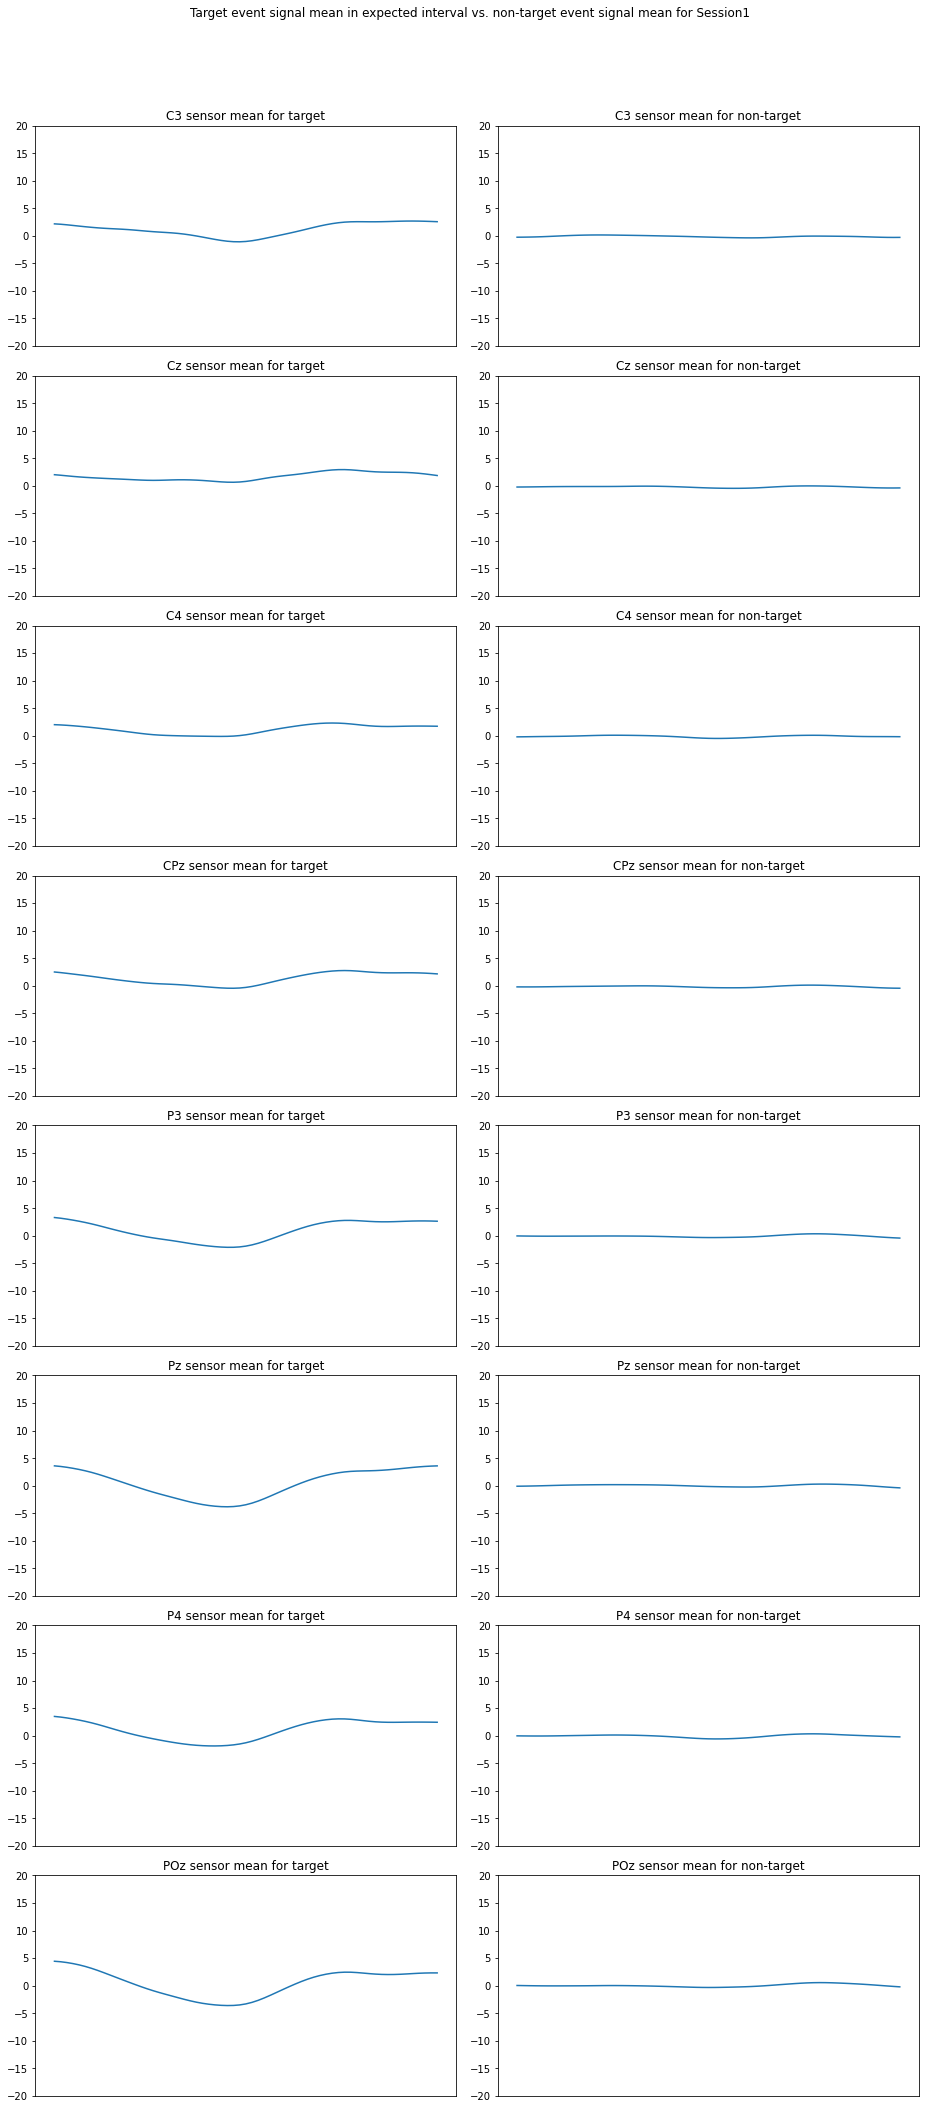

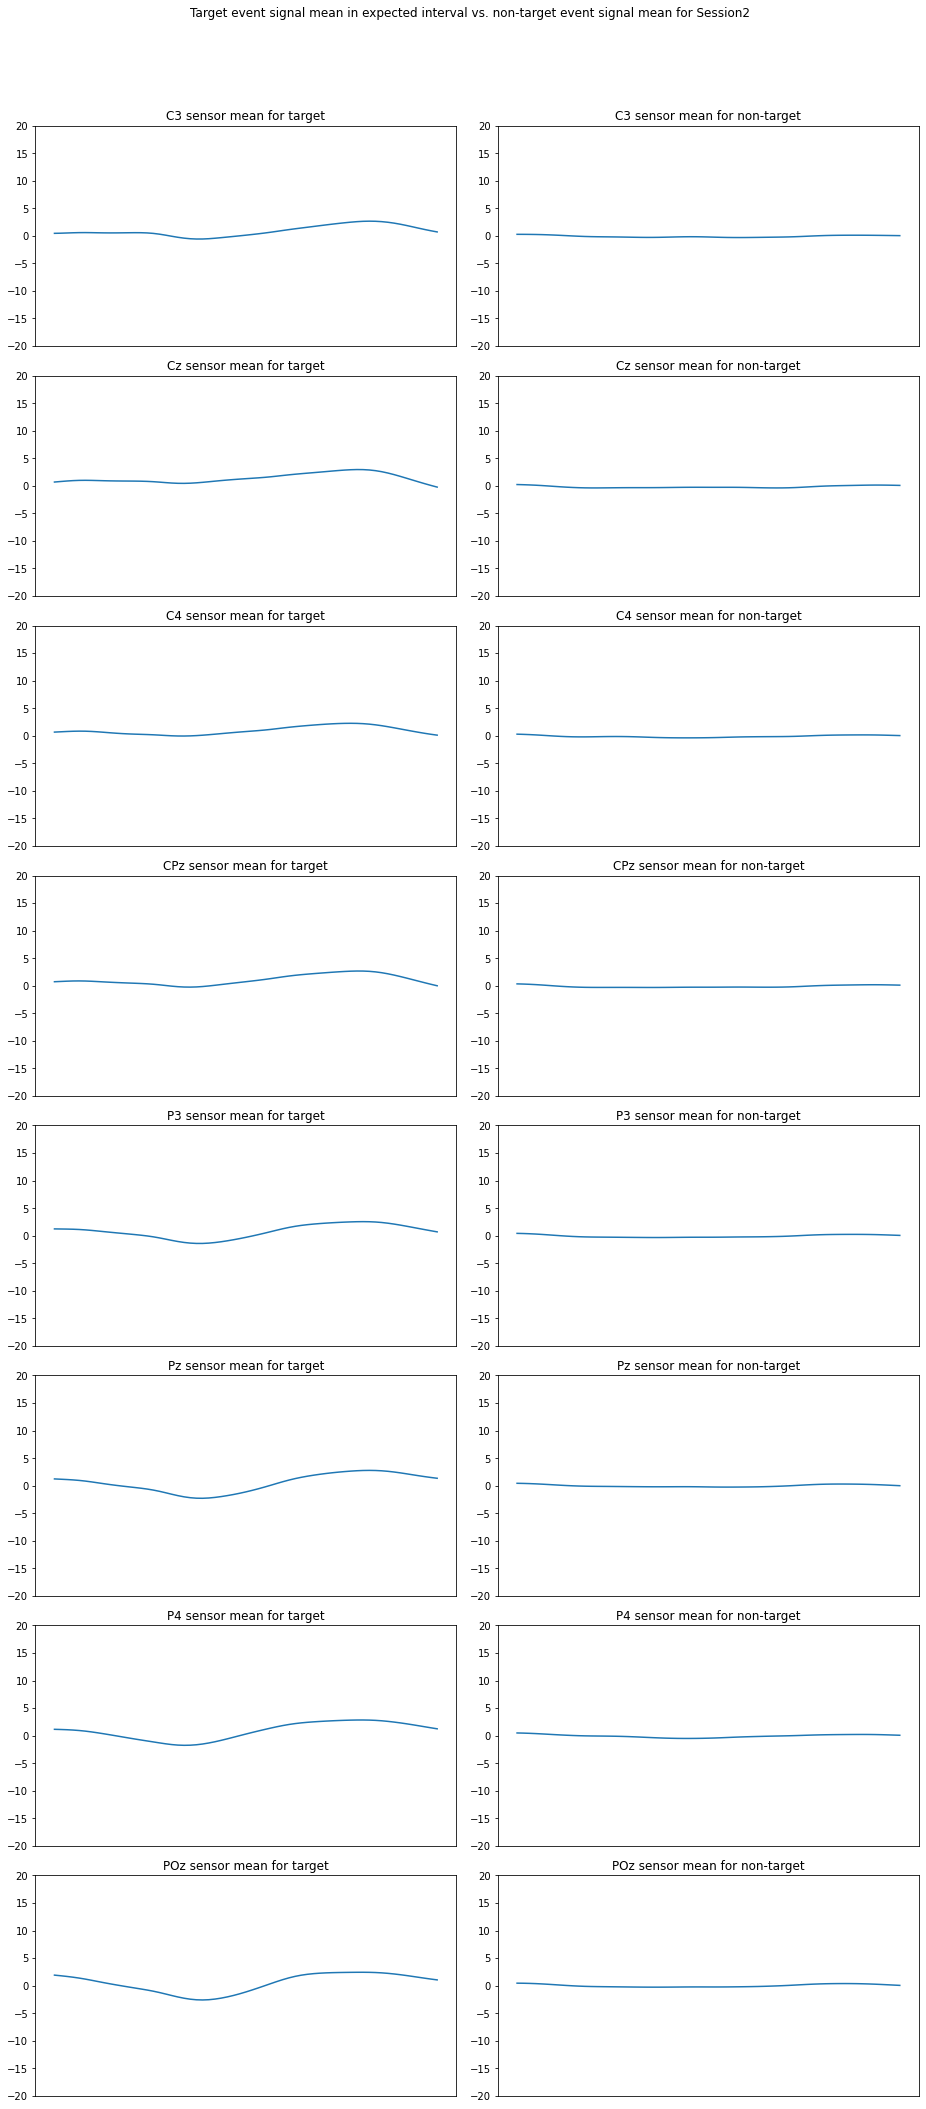

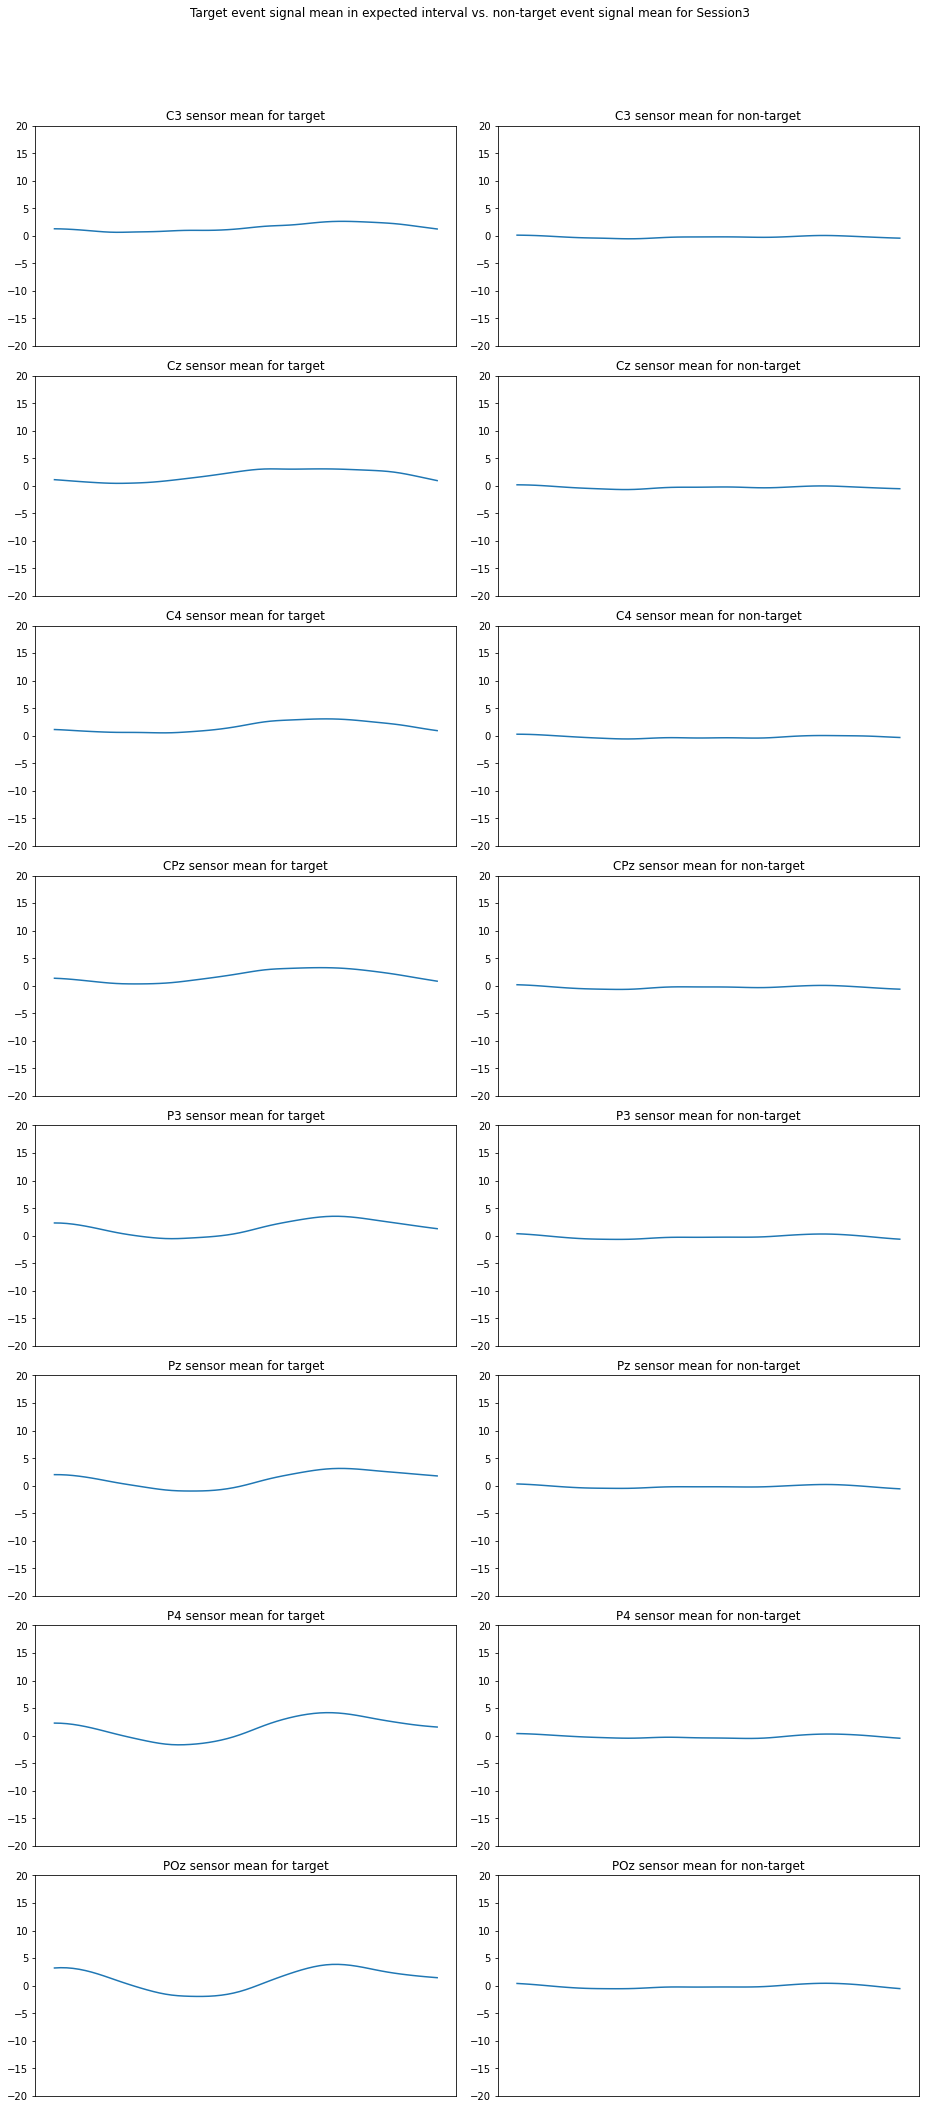

In [49]:
# Plotting the mean for each sensor for the expected interval of the p300 for each session for the target events
# vs the non-target events
for i in range(3):
    fig = plt.figure(figsize=(13,30))
    fig.subplots(8,2)
    fig.suptitle("Target event signal mean in expected interval vs. non-target event signal mean for Session"+str(i+1))
    plt.tight_layout()
    plt.subplots_adjust(top=0.925)
    for j in range(8):
        start_session = i*1600
        end_session = start_session + 1600
        target_data=[]
        non_target_data=[]

        for event in range(start_session,end_session):
            if train_targets.iloc[event].item() == 1:
                target_data.append(sg_data[j,112:175,event]) #sensor;signal;run
            else:
                non_target_data.append(sg_data[j,112:175,event])
                
        mean_target = np.array(target_data).mean(axis=0)
        mean_non_target = np.array(non_target_data).mean(axis=0)
        
        ax = plt.subplot(8,2,2*j+1)
        ax.set_ylim([-20,20])
        plt.xticks([])
        plt.title(channels[j] + " sensor mean for target")
        plt.plot(range(63),mean_target)

        ax = plt.subplot(8,2,2*j+2)
        ax.set_ylim([-20,20])
        plt.xticks([])
        plt.title(channels[j] + " sensor mean for non-target")   
        plt.plot(range(63),mean_non_target)
    plt.show()  

#### As an additional preprocessing technique besides the Savitzky-Golay filter, we added an implementation for a band-pass filter whose goal is to filter the frequencies in the range (0.1Hz , 20Hz), again due to the high SNR that EEG signals capture in their nature. The results of the filtering are visually displayed below alongside the Savitzky-Golay filter to compare the two approaches. The filtering is done on SBJ01, event 0 for run 0 in the first block of the first session

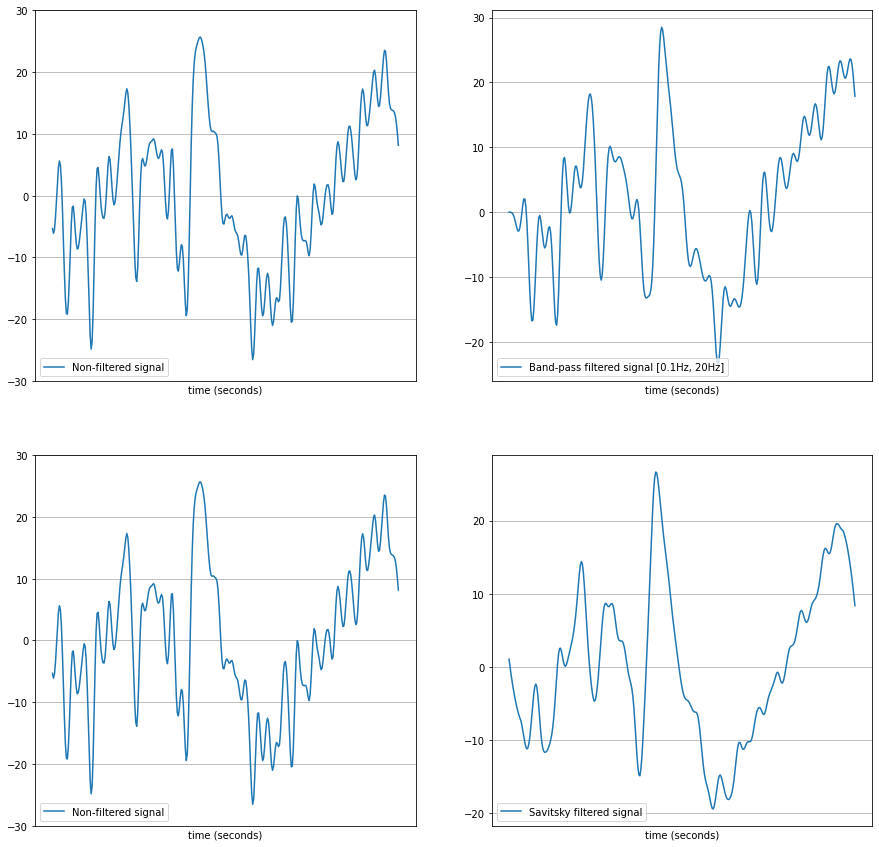

In [52]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 250.0
lowcut = 0.1
highcut = 20

fig = plt.figure(figsize=(15,15))
fig.subplots(2,2)

ax = plt.subplot(2,2,1)
ax.set_ylim([-30,30])
plt.xticks([])
plt.plot(range(350), data[0,:,0], label='Non-filtered signal')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='lower left')

plt.subplot(2,2,2)
ax.set_ylim([-30,30])
plt.xticks([])
y = butter_bandpass_filter(data[0,:,0], lowcut, highcut, fs, order=6)
plt.plot(range(350), y, label='Band-pass filtered signal [0.1Hz, 20Hz]')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='lower left')

ax = plt.subplot(2,2,3)
ax.set_ylim([-30,30])
plt.xticks([])
plt.plot(range(350), data[0,:,0], label='Non-filtered signal')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='lower left')

plt.subplot(2,2,4)
ax.set_ylim([-30,30])
plt.xticks([])
plt.plot(range(350), sg_data[0,:,0], label='Savitsky filtered signal')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='lower left')

plt.show()

#### We can see that the two approaches both combat the high SNR for the EEG signal, even though they do it in a slightly different matter. For this reason, we will consider implementing both in a certain way on our final data preprocessing pipeline and during the model development and validation phase see if keeping them both is redundant or not. 

# Defining input and output shape and model strategy

#### Upon exhaustive analysis we concluded the succeeding strategy in defining the input and output shape alongside the strategy for the model implementation. As a note of importance, the following definitions are simply a baseline idea which we evaluated as a good starting point for this problem : 

##### 1. Model - The model will be separated into two parts. The first will be a simple CNN whose task would be to predict the probability of an event (a flash of an object) inducing a P300 wave. The second model would be a form of a weight function which will use the output of the first model, aggregating it using some function f=f(X_i) where X_i is a vector of probabilities of size j depicting the probabilities that object i induced a P300 wave in total of j runs resulting in a vector of 10 elements (for the calibration phase). Thus f(X_i) would represent a way to assign a weighted probability to object i stating its likelihood of being the true object of focus in the certain block. Furthermore, this would mean that in order to generate the X vector for all objects we need to train the first model 80 (8 objects x 10 runs) times for a single block. After obtaining the X vectors for each object and using f(X) upon them the second model picks the label (object) corresponding to the max value of f(X) essentialy picking the object which in a way has the highest overall probability in a block to induce a p300 wave. The f=f(X) function as a starting point could be a simple sum of the elements of X, f=sum(X).

##### 2. Input - The input for the first model will be an event which is a matrix with the shape (num_sensors,num_samples) = (8, 350). The input of the second model will be an array of vectors of probabilities with the shape (num_vectors,num_elements_per_vector) = (8, 10)

##### 3. Output - The output of the first model is the previously mentioned input to the second model. The output of the second model is a label corresponding to the predicted object of interest in the block

##### An example flow of the model : We train the first model (the CNN) using the whole training dataset for SBJ1 by supplying it 4800 (1600x3) events. The network learns to predict the probability that an event induces a P300 wave or not for subject 1. During prediction time for a block, we use the CNN num_runs_per_block * num_events_per_run to generate 8 vectors of size num_runs_per_block. Lets say we have a block of 4 runs. In each run, there are 8 events, resulting in a total of 32 events. We use the CNN 32 times to generate a total of 8 X_i  vectors with sizes 4. Each vector contains 4 probabilities where probability j corresponds to the probability that the object i in run j generates a P300 wave (which is an output of the CNN). After getting the X_i vectors, we put them through a sample function f(X_i)=sum(X_i) thus summing each vector's elements. From 8 vectors we get 8 values that finally correspond to a weight of an object. We can pick the object with the maximum weight and choose that as our output label. This can be expanded by using a more complex strategy to pick the function f and by that pick a more complex second model.   


# Phase 3

### Defining the necessary functions, description in order:
1. Function needed for the bandpass filter (that we will use to smoothen out the data)
2. Bandpass filter
3. Fit and score function for our models
4. Graph loss plotting function
5. Function to cross validate our models with different splits
6. Custom method for splitting the data randomply (per block instead of per event)
7. TensorFlow random seed function

In [53]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def fit_model_and_score(model, model_name,
                        x_train_arg, y_train_arg, x_valid_arg, y_valid_arg,
                        verbose=False, epochs=30, val_split=True):
    x_train_arg = x_train_arg.reshape(x_train_arg.shape[0],x_train_arg.shape[1],x_train_arg.shape[2],1)
    x_valid_arg = x_valid_arg.reshape(x_valid_arg.shape[0],x_valid_arg.shape[1],x_valid_arg.shape[2],1)
    
    with tf.device('/device:gpu:0'):
        if val_split:
            logger_file = model_name+"_log"
            csv_logger = CSVLogger(logger_file)
            model.fit(x_train_arg,y_train_arg,epochs=epochs,callbacks=[csv_logger],validation_split=0.2,verbose=0)
        else:
            model.fit(x_train_arg, y_train_arg, epochs=epochs, verbose=0)
    predictions = model.predict(x_valid_arg)
    predictions = [1 if pred>0.5 else 0 for pred in predictions]
    if verbose:
        print("\nModel {} info:".format(model_name))
        print("====================================================================")
        print("Model accuracy: ", sklearn.metrics.accuracy_score(y_valid_arg, predictions))
        print("Precision score: ", sklearn.metrics.precision_score(y_valid_arg, predictions))
        print("Recall score: ", sklearn.metrics.recall_score(y_valid_arg, predictions))
        print("F1 score: ", sklearn.metrics.f1_score(y_valid_arg, predictions))
        print("====================================================================")
    
    
def plot_graph_loss(file_name, model_name):
    """
    Plots validation and train loss,
    :param file_name: name of the csv file containing values for validation and train loss functions
    :type file_name: str
    :param model_name: name of the model
    :type model_name: str
    """
    values = pd.read_table(file_name, sep=',')
    data = pd.DataFrame()
    data['epoch'] = list(values['epoch'].values + 1) + list(values['epoch'].values + 1)
    data['loss name'] = ['training'] * len(values) + ['validation'] * len(values)
    data['loss'] = list(values['loss'].values) + list(values['val_loss'].values)
    f, ax = plt.subplots()
    sns.lineplot(x='epoch', y='loss', hue='loss name', style='loss name', dashes=False, data=data, palette='Set2')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend().texts[0].set_text('')
    plt.title(model_name)
    plt.show()


def cross_validate(model, X, y, labels, events, subject_no, fold=5, new_model=False):
    total_acc, total_pre, total_rec, total_f1 = (0, 0, 0, 0)
    rands = random.sample(range(50), fold)
    print("Training network for subject ",subject_no+1,"!")
    for folds in range(fold):
        X_train, X_test, y_train, y_test, labels_test, events_test = my_split(X, y, labels, events,
                                                                              random_state=rands[folds])
        
        if new_model:
            X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
            es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30)
            with tf.device("/GPU:0"):
                model.fit(X_train, y_train, epochs=100, callbacks=[es], verbose=0)
        else:
            fit_model_and_score(model, "medicon_model_"+str(subject_no+1).zfill(2),
                            X_train, y_train, X_test, y_test, val_split=False, epochs=35)

        subject_pred = []
        
        for block_no, label in enumerate(labels_test):
            offset_low = int(block_no*80)
            offset_high = int(offset_low+80)
            block_events = X_test[offset_low:offset_high,:,:].reshape(80,X_test.shape[1],X_test.shape[2],1)
            preds = model.predict(block_events)
            test_events_block = events_test[offset_low:offset_high]
            end_vector = np.zeros(8)
            for index in range(80):
                end_vector[test_events_block[index]-1]+=preds[index]
            subject_pred.append(np.argmax(end_vector)+1)
        total_acc += sklearn.metrics.accuracy_score(labels_test,subject_pred)
        total_pre += sklearn.metrics.precision_score(labels_test,subject_pred, average='macro')
        total_rec += sklearn.metrics.recall_score(labels_test,subject_pred, average='macro')
        total_f1 += sklearn.metrics.f1_score(labels_test,subject_pred, average='macro')
    return total_acc/fold, total_pre/fold, total_rec/fold, total_f1/fold


def my_split(X, y, labels, events, session_runs=[10,10,10], blocks=20, test_size=0.2, random_state=None):
    num_events = sum(session_runs * 8) * blocks
    if num_events != np.shape(X)[0]:
        raise Exception('Values of session_runs and blocks do not correspond to shape of X!')
    X_train = list()
    X_test = list()
    y_train = list()
    y_test = list()
    labels_test = list()
    events_test = list()
    for s in session_runs:
        X_blocks = list()
        y_blocks = list()
        event_blocks = list()
        for b in range(blocks):
            X_blocks.append(X[:s*8,:,:])
            y_blocks.append(y[:s*8])
            event_blocks.append(events[:s*8])
            X = X[s*8:,:,:]
            y = y[s*8:]
            events = events[s*8:]
        temp = train_test_split(X_blocks, y_blocks, labels[:blocks], event_blocks,
                                test_size=test_size, random_state=random_state)
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = temp[:4]
        labels_test_temp = temp[5]
        events_test_temp = temp[7]
        labels = labels[blocks:]
        t = [X_train.append(j) for i in X_train_temp for j in i]
        t = [X_test.append(j) for i in X_test_temp for j in i]        
        t = [y_train.append(j) for i in y_train_temp for j in i]        
        t = [y_test.append(j) for i in y_test_temp for j in i]  
        t = [labels_test.append(j) for j in labels_test_temp]
        t = [events_test.append(j) for i in events_test_temp for j in i]
    return (np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test),
            np.array(labels_test), np.array(events_test))


def init_seeds(seed):
    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    return sess

#### Load the data for the first subject in order to visualize the train and validation loss for the P300 detection model on bandpass filtered, Savitzky-Golay filtered and raw data.

In [0]:
train_folder = "medicon_data/subjects_post/SBJ"
file = train_folder+"01/Train"
mat = scipy.io.loadmat(os.path.join(file,"trainData"))
data = mat['trainData']
savgol_data = savgol_filter(data,25,2,axis=1)
bandpass_data = butter_bandpass_filter(data, 0.1, 20, 250.0)
train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))

#### Our model is built exactly as we specified in phase 2: 
First we create a convolutional layer with 16 filters that slide along the temporal axis 14 times (with size 8x25, stride=25). The filters take all 8 channels into account, meaning there isn't any sliding of the window along that axis, so the output of this layer is a 16x14 matrix. Next we flatten this matrix into 224 neurons, after adding regilarization with a dropout layer that randomly sets one quarter of the inputs of the neurons to 0. Finally, these 224 neurons connect to one output neuron with sigmoidal activation function that will give us the probability that a P300 signal occured in the given event.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 14, 16)         3216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 14, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 225       
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________

Model medicon_bandpass_filtered info:
Model accuracy:  0.875
Precision score:  0.0
Recall score:  0.0
F1 score:  0.0


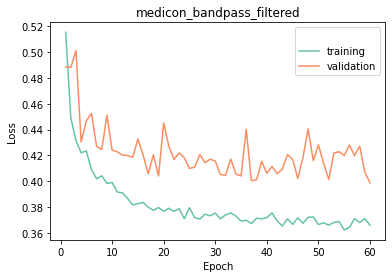


Model medicon_savgol_filtered info:
Model accuracy:  0.8770833333333333
Precision score:  0.5294117647058824
Recall score:  0.15
F1 score:  0.23376623376623373


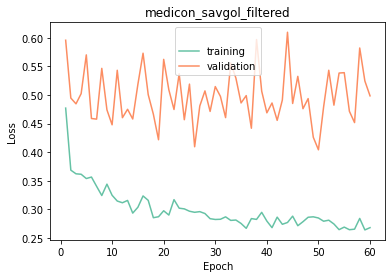


Model medicon_raw_data info:
Model accuracy:  0.875
Precision score:  0.5
Recall score:  0.175
F1 score:  0.25925925925925924


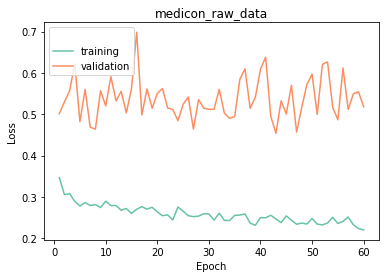

In [0]:
# Training the CNN with 16 filters of size (350/15,8) on SBJ01
my_model = Sequential()
N = 350
batch = 14
channels = 8

my_model.add(layers.Conv2D(16, kernel_size=(8,int(N/batch)), strides=(8,int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
my_model.add(layers.Dropout(0.25))
my_model.add(layers.Flatten())
my_model.add(layers.Dense(1, activation='sigmoid'))
my_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
my_model.summary()

y = train_targets['Values'].values

# ========================================= BANDPASS =========================================

X = np.array([bandpass_data[:,:,i] for i in range(4800)])
file_name = "medicon_bandpass_filtered"

X_train, X_test, y_train, y_test, labels_test, events_test = my_split(X, y, train_labels,
                                                                      train_events, random_state=42)

fit_model_and_score(my_model,file_name,X_train,y_train,X_test,y_test,verbose=True,epochs=60)
plot_graph_loss(file_name+"_log",file_name)

# ====================================== SAVITZKY-GOLAY ======================================

X = np.array([savgol_data[:,:,i] for i in range(4800)])
file_name = "medicon_savgol_filtered"

X_train, X_test, y_train, y_test, labels_test, events_test = my_split(X, y, train_labels,
                                                                      train_events, random_state=42)

fit_model_and_score(my_model,file_name,X_train,y_train,X_test,y_test,verbose=True,epochs=60)
plot_graph_loss(file_name+"_log",file_name)

# ========================================= RAW DATA =========================================

X = np.array([data[:,:,i] for i in range(4800)])
file_name = "medicon_raw_data"

X_train, X_test, y_train, y_test, labels_test, events_test = my_split(X, y, train_labels,
                                                                      train_events, random_state=42)

fit_model_and_score(my_model,file_name,X_train,y_train,X_test,y_test,verbose=True,epochs=60)
plot_graph_loss(file_name+"_log",file_name)

These visualizations don't give an elbow in the number of epochs, which means we can't estimate the best number for this parameter (unless we use grid search), so we will use 30-35 epochs in training. This is because we don't have much data, but yet the model is very simple, so the number of epochs being in this range seems reasonable.

As for the models, they aren't great, especially the one on the bandpass data, which predicts only class 0. But, this is only the P300 detection part and the results are achieved with tresholding the output from the network. The prediction of the target event in a block will be computed using the P300 detection model **events_per_run** * **runs_per_block** times, generating probabilities for each event. Summing these probabilities per event (for each block) provides us with a list of 8 floats, one for each event. Our model will predict the argmax of this list as the target event in that block. In next 3 cells we test this model for each subject on our 3 forms of data accordingly. We apply 5 fold cross validation that uses our own data splitting method which utilizes per block division, in order to train and test on whole blocks, not just chunks.

In [0]:
# Pipeline for evaluation of each subject on bandpass filtered data
train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    bp_data = butter_bandpass_filter(data, 0.1, 20, 250.0)
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([bp_data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    labels = train_labels['Values'].values
    events = train_events['Values'].values
    
    accuracy, precision, recall, f1 = cross_validate(my_model, X, y, labels, events, subject_no)

    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    print("Accuracy: ",round(accuracy, 4))
    print("Precision: ",round(precision, 4))
    print("Recall: ",round(recall, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
    total_accuracy += accuracy
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.3333
Precision:  0.2354
Recall:  0.3175
F1:  0.2464
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  0.5833
Precision:  0.5562
Recall:  0.4789
F1:  0.4894
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  0.3667
Precision:  0.3673
Recall:  0.3544
F1:  0.3334
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  0.4
Precision:  0.3405
Recall:  0.2783
F1:  0.2867
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.5
Precision:  0.4101
Recall:  0.4905
F1:  0.4266
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  0.3167
Precision:  0.2905
Recall:  0.2667
F1:  0.2677
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  0.6167
Precision:  0.5287
Recall:  0.5417
F1:  0.5085
Training network for subject  8 !
Printing statistics for sub

In [0]:
# Pipeline for evaluation of each subject on Savitzky-Golay filtered data
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    sg_data = savgol_filter(data,25,2,axis=1)
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([sg_data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    labels = train_labels['Values'].values
    events = train_events['Values'].values
    
    accuracy, precision, recall, f1 = cross_validate(my_model, X, y, labels, events, subject_no)

    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    print("Accuracy: ",round(accuracy, 4))
    print("Precision: ",round(precision, 4))
    print("Recall: ",round(recall, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
    total_accuracy += accuracy
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.7167
Precision:  0.6631
Recall:  0.6881
F1:  0.6529
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  0.95
Precision:  0.9413
Recall:  0.9357
F1:  0.9298
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  0.9333
Precision:  0.9095
Recall:  0.919
F1:  0.9086
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.9833
Precision:  0.9889
Recall:  0.9917
F1:  0.9886
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  0.9667
Precision:  0.9444
Recall:  0.9583
F1:  0.9452
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  0.9667
Precision:  0.9689
Recall:  0.9733
F1:  0.9632
Training network for subject  8 !
Printing statistics for subject:  8


In [0]:
# Pipeline for evaluation of each subject on raw data
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    labels = train_labels['Values'].values
    events = train_events['Values'].values
    
    accuracy, precision, recall, f1 = cross_validate(my_model, X, y, labels, events, subject_no)

    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    print("Accuracy: ",round(accuracy, 4))
    print("Precision: ",round(precision, 4))
    print("Recall: ",round(recall, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
    total_accuracy += accuracy
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.8
Precision:  0.7393
Recall:  0.7375
F1:  0.7164
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  0.9667
Precision:  0.9524
Recall:  0.9643
F1:  0.9559
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  0.8833
Precision:  0.8744
Recall:  0.8825
F1:  0.8544
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.9833
Precision:  0.9867
Recall:  0.99
F1:  0.9863
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  0.9833
Precision:  0.9714
Recall:  0.9571
F1:  0.9619
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  8 !
Printing statistics for subject:  8
Accuracy:  1.0

### Discussion about the results
The bandpass filter dissapointed, but our model works very well on both Savitzky-Golay filtered and raw data, maybe even too well. Next, we test the model with the last 4 blocks of each session, while train on all blocks before those. This kind of split seems resonable due to the fact that the online phase in each session comes after the callibration, and since we train on the callibration and will test on the online phase this split will give us insight into how well our model deals with temporal dependencies (if there are any) between these two phases.

Note: We won't test our model using the bandpass filter anymore, since it provides very bad results compared to the other filter / raw data.

In [0]:
train_folder = "medicon_data/subjects_post/SBJ"
file = train_folder+"01/Train"
mat = scipy.io.loadmat(os.path.join(file,"trainData"))
data = mat['trainData']
savgol_data = savgol_filter(data,25,2,axis=1)
bandpass_data = butter_bandpass_filter(data, 0.1, 20, 250.0)
train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 14, 16)         3216      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 14, 16)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 225       
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________

Model medicon_bandpass_filtered info:
Model accuracy:  0.875
Precision score:  0.0
Recall score:  0.0
F1 score:  0.0


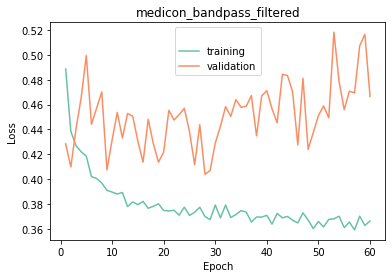


Model medicon_savgol_filtered info:
Model accuracy:  0.8854166666666666
Precision score:  0.9166666666666666
Recall score:  0.09166666666666666
F1 score:  0.16666666666666666


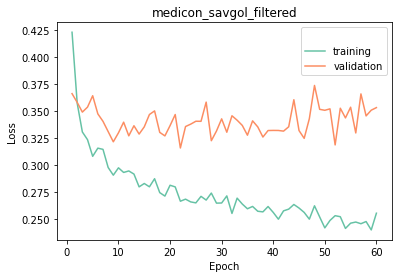


Model medicon_raw_data info:
Model accuracy:  0.8458333333333333
Precision score:  0.325
Recall score:  0.21666666666666667
F1 score:  0.25999999999999995


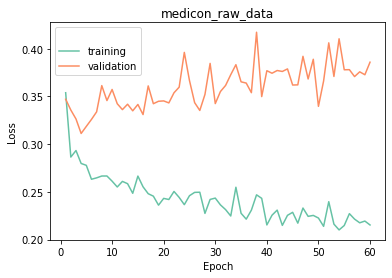

In [0]:
# Testing the first part of the model on SBJ01 with sequential splits (last 4 blocks are test)
my_model = Sequential()
N = 350
batch = 14
channels = 8

my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
my_model.add(layers.Dropout(0.25))
my_model.add(layers.Flatten())
my_model.add(layers.Dense(1, activation='sigmoid'))
my_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
my_model.summary()

y = train_targets['Values'].values

# ========================================= BANDPASS =========================================

X = np.array([bandpass_data[:,:,i] for i in range(4800)])
file_name = "medicon_bandpass_filtered"

X_train= np.concatenate((X[:1280,:,:], X[1600:2880,:,:], X[3200:4480,:,:]))
X_test = np.concatenate((X[1280:1600,:,:], X[2880:3200,:,:], X[4480:4800,:,:]))
y_train= np.concatenate((y[:1280], y[1600:2880], y[3200:4480]))
y_test = np.concatenate((y[1280:1600], y[2880:3200], y[4480:4800]))

fit_model_and_score(my_model,file_name,X_train,y_train,X_test,y_test,verbose=True,epochs=60)
plot_graph_loss(file_name+"_log",file_name)

# ====================================== SAVITZKY-GOLAY ======================================

X = np.array([savgol_data[:,:,i] for i in range(4800)])
file_name = "medicon_savgol_filtered"

X_train= np.concatenate((X[:1280,:,:], X[1600:2880,:,:], X[3200:4480,:,:]))
X_test = np.concatenate((X[1280:1600,:,:], X[2880:3200,:,:], X[4480:4800,:,:]))
y_train= np.concatenate((y[:1280], y[1600:2880], y[3200:4480]))
y_test = np.concatenate((y[1280:1600], y[2880:3200], y[4480:4800]))

fit_model_and_score(my_model,file_name,X_train,y_train,X_test,y_test,verbose=True,epochs=60)
plot_graph_loss(file_name+"_log",file_name)

# ========================================= RAW DATA =========================================

X = np.array([data[:,:,i] for i in range(4800)])
file_name = "medicon_raw_data"

X_train= np.concatenate((X[:1280,:,:], X[1600:2880,:,:], X[3200:4480,:,:]))
X_test = np.concatenate((X[1280:1600,:,:], X[2880:3200,:,:], X[4480:4800,:,:]))
y_train= np.concatenate((y[:1280], y[1600:2880], y[3200:4480]))
y_test = np.concatenate((y[1280:1600], y[2880:3200], y[4480:4800]))

fit_model_and_score(my_model,file_name,X_train,y_train,X_test,y_test,verbose=True,epochs=60)
plot_graph_loss(file_name+"_log",file_name)

In [0]:
# Pipeline for evaluation of each subject on Svaitzky-Golay filtered data
# with last 4 blocks of each session as test set
train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    sg_data = savgol_filter(data,25,2,axis=1)
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([sg_data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    
    X_train= np.concatenate((X[:1280,:,:], X[1600:2880,:,:], X[3200:4480,:,:]))
    X_test = np.concatenate((X[1280:1600,:,:], X[2880:3200,:,:], X[4480:4800,:,:]))
    y_train= np.concatenate((y[:1280], y[1600:2880], y[3200:4480]))
    y_test = np.concatenate((y[1280:1600], y[2880:3200], y[4480:4800]))
    
    print("Training network for subject ",subject_no+1,"!")
    fit_model_and_score(my_model,"medicon_model_"+str(subject_no+1).zfill(2),X_train,
                        y_train,X_test,y_test)
    #plot_graph_loss(file_name+"_log",file_name)
    labels = train_labels['Values'].values
    labels = list(labels[16:20])+list(labels[36:40])+list(labels[56:60])
    subject_pred = []
    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    
    for block_no in list(range(16,20))+list(range(36,40))+list(range(56,60)):
        offset_low = int(block_no*80)
        offset_high = int(offset_low+80)
        block_events = X[offset_low:offset_high,:,:].reshape(80,X.shape[1],X.shape[2],1)
        preds = my_model.predict(block_events)
        train_events_block = train_events['Values'].values[offset_low:offset_high]
        end_vector = np.zeros(8)
        for index in range(80):
            end_vector[train_events_block[index]-1]+=preds[index]
        subject_pred.append(np.argmax(end_vector)+1)    
    acc = sklearn.metrics.accuracy_score(labels,subject_pred)
    pre = sklearn.metrics.precision_score(labels,subject_pred, average='macro')
    rec = sklearn.metrics.recall_score(labels,subject_pred, average='macro')
    f1 = sklearn.metrics.f1_score(labels,subject_pred, average='macro')
    total_accuracy+=acc
    print("Accuracy: ",round(acc, 4))
    print("Precision: ",round(pre, 4))
    print("Recall: ",round(rec, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.75
Precision:  0.7778
Recall:  0.6667
F1:  0.7111
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  0.9167
Precision:  0.9286
Recall:  0.9643
F1:  0.932
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  0.9167
Precision:  0.9643
Recall:  0.9524
F1:  0.951
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.9167
Precision:  0.9286
Recall:  0.9286
F1:  0.9048
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  0.9167
Precision:  0.7917
Recall:  0.8333
F1:  0.8095
Training network for subject  8 !
Printing statistics for subject:  8
Accuracy:  0.

In [0]:
# Pipeline for evaluation of each subject on raw data with last 4 blocks of each session as test set
train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    
    X_train= np.concatenate((X[:1280,:,:], X[1600:2880,:,:], X[3200:4480,:,:]))
    X_test = np.concatenate((X[1280:1600,:,:], X[2880:3200,:,:], X[4480:4800,:,:]))
    y_train= np.concatenate((y[:1280], y[1600:2880], y[3200:4480]))
    y_test = np.concatenate((y[1280:1600], y[2880:3200], y[4480:4800]))
    
    print("Training network for subject ",subject_no+1,"!")
    fit_model_and_score(my_model,"medicon_model_"+str(subject_no+1).zfill(2),X_train,
                        y_train,X_test,y_test)
    #plot_graph_loss(file_name+"_log",file_name)
    labels = train_labels['Values'].values
    labels = list(labels[16:20])+list(labels[36:40])+list(labels[56:60])
    subject_pred = []
    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    
    for block_no in list(range(16,20))+list(range(36,40))+list(range(56,60)):
        offset_low = int(block_no*80)
        offset_high = int(offset_low+80)
        block_events = X[offset_low:offset_high,:,:].reshape(80,X.shape[1],X.shape[2],1)
        preds = my_model.predict(block_events)
        train_events_block = train_events['Values'].values[offset_low:offset_high]
        end_vector = np.zeros(8)
        for index in range(80):
            end_vector[train_events_block[index]-1]+=preds[index]
        subject_pred.append(np.argmax(end_vector)+1)
    acc = sklearn.metrics.accuracy_score(labels,subject_pred)
    pre = sklearn.metrics.precision_score(labels,subject_pred, average='macro')
    rec = sklearn.metrics.recall_score(labels,subject_pred, average='macro')
    f1 = sklearn.metrics.f1_score(labels,subject_pred, average='macro')
    total_accuracy+=acc
    print("Accuracy: ",round(acc, 4))
    print("Precision: ",round(pre, 4))
    print("Recall: ",round(rec, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.6667
Precision:  0.619
Recall:  0.5238
F1:  0.5476
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  0.9167
Precision:  0.875
Recall:  0.8125
F1:  0.8333
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.9167
Precision:  0.9286
Recall:  0.9286
F1:  0.9048
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  0.8333
Precision:  0.7778
Recall:  0.7778
F1:  0.7778
Training network for subject  8 !
Printing statistics for subject:  8
Accuracy:  1.0
Precisio

#### As we can see, the results are about 7% worse with this split instead of the random one. Also, we can see that our model performs worse on some subjects. The next validation step is training on first and second session, while testing on the third, to see the performance of our model on data from an unseen session.

In [0]:
# Pipeline for evaluation of each subject on Savitzky-Golay filtered data with third session as test set
train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    sg_data = savgol_filter(data,25,2,axis=1)
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    
    X_train = X[:3200]
    X_test = X[3200:]
    y_train = y[:3200]
    y_test = y[3200:]
    
    print("Training network for subject ",subject_no+1,"!")
    fit_model_and_score(my_model,"medicon_model_"+str(subject_no+1).zfill(2),X_train,
                        y_train,X_test,y_test)
    labels = train_labels['Values'].values
    labels = list(labels[40:60])
    subject_pred = []
    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    
    for block_no in range(40,60):
        offset_low = int(block_no*80)
        offset_high = int(offset_low+80)
        block_events = X[offset_low:offset_high,:,:].reshape(80,X.shape[1],X.shape[2],1)
        preds = my_model.predict(block_events)
        train_events_block = train_events['Values'].values[offset_low:offset_high]
        end_vector = np.zeros(8)
        for index in range(80):
            end_vector[train_events_block[index]-1]+=preds[index]
        subject_pred.append(np.argmax(end_vector)+1)
    acc = sklearn.metrics.accuracy_score(labels,subject_pred)
    pre = sklearn.metrics.precision_score(labels,subject_pred, average='macro')
    rec = sklearn.metrics.recall_score(labels,subject_pred, average='macro')
    f1 = sklearn.metrics.f1_score(labels,subject_pred, average='macro')
    total_accuracy+=acc
    print("Accuracy: ",round(acc, 4))
    print("Precision: ",round(pre, 4))
    print("Recall: ",round(rec, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.6
Precision:  0.5095
Recall:  0.5048
F1:  0.4929
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  0.9
Precision:  0.9
Recall:  0.8929
F1:  0.8685
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  0.85
Precision:  0.8095
Recall:  0.7333
F1:  0.7468
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  0.85
Precision:  0.875
Recall:  0.8958
F1:  0.8667
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.9
Precision:  0.9333
Recall:  0.9375
F1:  0.9194
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  0.85
Precision:  0.8083
Recall:  0.7917
F1:  0.7944
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  0.85
Precision:  0.8708
Recall:  0.875
F1:  0.8319
Training network for subject  8 !
Printing statistics for subject:  8
Accurac

In [0]:
# Pipeline for evaluation of each subject on raw data with third session as test set
train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(int(N/batch),int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    
    X_train = X[:3200]
    X_test = X[3200:]
    y_train = y[:3200]
    y_test = y[3200:]
    
    print("Training network for subject ",subject_no+1,"!")
    fit_model_and_score(my_model,"medicon_model_"+str(subject_no+1).zfill(2),X_train,
                        y_train,X_test,y_test)
    labels = train_labels['Values'].values
    labels = list(labels[40:60])
    subject_pred = []
    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    
    for block_no in range(40,60):
        offset_low = int(block_no*80)
        offset_high = int(offset_low+80)
        block_events = X[offset_low:offset_high,:,:].reshape(80,X.shape[1],X.shape[2],1)
        preds = my_model.predict(block_events)
        train_events_block = train_events['Values'].values[offset_low:offset_high]
        end_vector = np.zeros(8)
        for index in range(80):
            end_vector[train_events_block[index]-1]+=preds[index]
        subject_pred.append(np.argmax(end_vector)+1)
    acc = sklearn.metrics.accuracy_score(labels,subject_pred)
    pre = sklearn.metrics.precision_score(labels,subject_pred, average='macro')
    rec = sklearn.metrics.recall_score(labels,subject_pred, average='macro')
    f1 = sklearn.metrics.f1_score(labels,subject_pred, average='macro')
    total_accuracy+=acc
    print("Accuracy: ",round(acc, 4))
    print("Precision: ",round(pre, 4))
    print("Recall: ",round(rec, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Training network for subject  1 !
Printing statistics for subject:  1
Accuracy:  0.6
Precision:  0.5833
Recall:  0.4417
F1:  0.4653
Training network for subject  2 !
Printing statistics for subject:  2
Accuracy:  0.95
Precision:  0.9714
Recall:  0.9714
F1:  0.9683
Training network for subject  3 !
Printing statistics for subject:  3
Accuracy:  0.85
Precision:  0.9028
Recall:  0.8694
F1:  0.8795
Training network for subject  4 !
Printing statistics for subject:  4
Accuracy:  0.9
Precision:  0.9167
Recall:  0.9271
F1:  0.9071
Training network for subject  5 !
Printing statistics for subject:  5
Accuracy:  0.85
Precision:  0.8083
Recall:  0.8125
F1:  0.7944
Training network for subject  6 !
Printing statistics for subject:  6
Accuracy:  0.8
Precision:  0.7042
Recall:  0.7292
F1:  0.7069
Training network for subject  7 !
Printing statistics for subject:  7
Accuracy:  0.95
Precision:  0.9375
Recall:  0.9583
F1:  0.9333
Training network for subject  8 !
Printing statistics for subject:  8
Ac

The results seem promising, even though our model is underperforming for some subjects, like 1 and 14. In the last cell we train the models on the whole data and save them in .h5 files.

In [0]:
# Save models
train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    sg_data = savgol_filter(data,25,2,axis=1)
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))

    my_model = Sequential()
    my_model.add(layers.Conv2D(16, (8,int(N/batch)),strides=(8,int(N/batch)), 
                           activation='relu',input_shape=(8,350,1)))
    my_model.add(layers.Dropout(0.25))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = train_targets['Values'].values
    
    print("Training network for subject",subject_no+1,"!")
    my_model.fit(X, y, epochs=30, verbose=0)
    print("Saving model for subject", subject_no+1)
    my_model.save("models/" + file_name + ".h5")

Training network for subject 1 !
Saving model for subject 1
Training network for subject 2 !
Saving model for subject 2
Training network for subject 3 !
Saving model for subject 3
Training network for subject 4 !
Saving model for subject 4
Training network for subject 5 !
Saving model for subject 5
Training network for subject 6 !
Saving model for subject 6
Training network for subject 7 !
Saving model for subject 7
Training network for subject 8 !
Saving model for subject 8
Training network for subject 9 !
Saving model for subject 9
Training network for subject 10 !
Saving model for subject 10
Training network for subject 11 !
Saving model for subject 11
Training network for subject 12 !
Saving model for subject 12
Training network for subject 13 !
Saving model for subject 13
Training network for subject 14 !
Saving model for subject 14
Training network for subject 15 !
Saving model for subject 15


# Extra: New model that performs better

In this section we introduce a new model that we stumbled upon while doing some extra research. This model is more complicated than our previous one and we expect it to give better results. Although, as a consequence of the lack of time until the deadline of this phase, we will not test is thoroughly as we did with the previous one, and will do that in the last phase of the project.

### Architecture 
We implement the EEGNet that utilizes depthwise and separable convolutions in order to construct EEG-specific DNN, referencing this paper \[[1](https://arxiv.org/pdf/1611.08024.pdf)]

The model is divided in 3 blocks consisting of:
 - Convolutional block (feature extraction)
 - Separable convolutions and
 - Classification

The goal of the first block is to perform two convolutions one after another. In previous research, we found that temporal convolutions yield better results when working with EEG signals, especially if they are applied before spacial, which is also the case in this NN, hence we expect good results. We chose the filter size based on the one in the paper adopted to our sample frequency (250/2 = 125). The output is then passed to a Depthwise Convolution in order for the model to learn the spacial characteristics of the data. The D parameter is the number of spatial filters to learn for each feature map. Afterwards, Batch Normalization and ReLU activation layers are added, as well as a 50% Dropout layer to prevent overfitting and an Average Pooling for dimensionality reduction.

Block 2 is characterized with a Separable Convolution layer which purpose, besides parameter reduction, is to decouple the relationships within and across feature maps. Maps are first summarized individually in order to form the kernel and then optimally merged. This works exceptionally well for EEG signals as explained in the paper. For further dimensionality reduction, an Average Pooling layer is added and another Dropout layer for regularization.

The output is simply flattened and given to the output layer with a sigmoid activation function in the 3rd Block.

The model is fit and trained in the few following cells and we give a result overview at the end. 




In [0]:
# NEW MODEL ON SAVITZKY-GOLAY FILTERED
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

train_folder = "/content/drive/My Drive/medicon_data/subjects_post/SBJ"
num_subjects = 15
p1=16
p2=8
D=4
sampling=250
num_blocks_per_subject = 60
num_blocks_per_subject_test = 80
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_events_per_subject_test = num_blocks_per_subject_test*num_events_per_block

my_model = Sequential()    
my_model.add(layers.Conv2D(p1,(1,125),activation='linear',input_shape=(8,350,1)))
my_model.add(layers.BatchNormalization(axis=-1)) 
my_model.add(layers.DepthwiseConv2D(depth_multiplier=D,kernel_size=(8,1),activation='linear'))
my_model.add(layers.BatchNormalization(axis=-1))
my_model.add(layers.ReLU())
my_model.add(layers.AveragePooling2D(pool_size=(1,5)))
#sampling is now 50hz
my_model.add(layers.Dropout(0.5))
my_model.add(layers.SeparableConv2D(p2,(1,28),activation='linear'))
my_model.add(layers.BatchNormalization(axis=-1))
my_model.add(layers.ReLU())
my_model.add(layers.AveragePooling2D(pool_size=(1,5)))
my_model.add(layers.Dropout(0.5))
my_model.summary()
my_model.add(layers.Flatten())
my_model.add(layers.Dense(1, activation='sigmoid'))
with tf.device('/GPU:0'):
    my_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    sg_data = savgol_filter(data,25,2,axis=1)
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([sg_data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    labels = train_labels['Values'].values
    events = train_events['Values'].values
    
    acc, pre, rec, f1 = cross_validate(my_model, X, y, labels, events, subject_no, new_model=True)
    
    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    print("Accuracy: ",round(acc, 4))
    print("Precision: ",round(pre, 4))
    print("Recall: ",round(rec, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
    total_accuracy += acc

print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 226, 16)        2016      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 226, 16)        64        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 226, 64)        576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 226, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 226, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 45, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 45, 64)         0

In [0]:
# NEW MODEL ON RAW DATA
my_model = Sequential()    
my_model.add(layers.Conv2D(p1,(1,125),activation='linear',input_shape=(8,350,1)))
my_model.add(layers.BatchNormalization(axis=-1)) 
my_model.add(layers.DepthwiseConv2D(depth_multiplier=D,kernel_size=(8,1),activation='linear'))
my_model.add(layers.BatchNormalization(axis=-1))
my_model.add(layers.ReLU())
my_model.add(layers.AveragePooling2D(pool_size=(1,5)))
#sampling is now 50hz
my_model.add(layers.Dropout(0.5))
my_model.add(layers.SeparableConv2D(p2,(1,28),activation='linear'))
my_model.add(layers.BatchNormalization(axis=-1))
my_model.add(layers.ReLU())
my_model.add(layers.AveragePooling2D(pool_size=(1,5)))
my_model.add(layers.Dropout(0.5))
my_model.summary()
my_model.add(layers.Flatten())
my_model.add(layers.Dense(1, activation='sigmoid'))
my_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
total_accuracy = 0
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    train_events = pd.read_csv(os.path.join(file,"trainEvents.csv"))
    train_labels = pd.read_csv(os.path.join(file,"trainLabels.csv"))
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))
    
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    y = train_targets['Values'].values
    labels = train_labels['Values'].values
    events = train_events['Values'].values

    acc, pre, rec, f1 = cross_validate(my_model, X, y, labels, events, subject_no, new_model=True)

    print("=========================================================")
    print("Printing statistics for subject: ",subject_no+1)
    print("Accuracy: ",round(acc, 4))
    print("Precision: ",round(pre, 4))
    print("Recall: ",round(rec, 4))
    print("F1: ",round(f1, 4))
    print("=========================================================")
    total_accuracy += acc

print("Final mean accuracy for every subject: ",round(total_accuracy/num_subjects,4))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 8, 226, 16)        2016      
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 226, 16)        64        
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 1, 226, 64)        576       
_________________________________________________________________
batch_normalization_31 (Batc (None, 1, 226, 64)        256       
_________________________________________________________________
re_lu_20 (ReLU)              (None, 1, 226, 64)        0         
_________________________________________________________________
average_pooling2d_20 (Averag (None, 1, 45, 64)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 45, 64)       

In [ ]:
# Save models
# train_folder = "medicon_data/subjects_post/SBJ"
num_subjects = 15
N = 350
batch = 14
channels = 8
num_blocks_per_subject = 60
num_blocks_per_session = 20
num_events_per_block = 80
total_events_per_subject = num_blocks_per_subject*num_events_per_block
total_accuracy = 0
class_weights = {0: 1, 1: 8}
for subject_no in range(num_subjects):
    file = train_folder+str(subject_no+1).zfill(2)+"/Train"
    mat = scipy.io.loadmat(os.path.join(file,"trainData"))
    data = mat['trainData']
    sg_data = savgol_filter(data,25,2,axis=1)
    train_targets = pd.read_csv(os.path.join(file,"trainTargets.csv"))

    my_model = Sequential()    
    my_model.add(layers.Conv2D(p1,(1,125),activation='linear',input_shape=(8,350,1)))
    my_model.add(layers.BatchNormalization(axis=-1)) 
    my_model.add(layers.DepthwiseConv2D(depth_multiplier=D,kernel_size=(8,1),activation='linear'))
    my_model.add(layers.BatchNormalization(axis=-1))
    my_model.add(layers.ReLU())
    my_model.add(layers.AveragePooling2D(pool_size=(1,5)))
    #sampling is now 50hz
    my_model.add(layers.Dropout(0.5))
    my_model.add(layers.SeparableConv2D(p2,(1,28),activation='linear'))
    my_model.add(layers.BatchNormalization(axis=-1))
    my_model.add(layers.ReLU())
    my_model.add(layers.AveragePooling2D(pool_size=(1,5)))
    my_model.add(layers.Dropout(0.5))
    my_model.add(layers.Flatten())
    my_model.add(layers.Dense(1, activation='sigmoid'))
    my_model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    file_name = "medicon_model_"+str(subject_no+1).zfill(2)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    X = np.array([data[:,:,i] for i in range(total_events_per_subject)])
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = train_targets['Values'].values
    
    print("Training network for subject",subject_no+1,"!")
    my_model.fit(X, y, epochs=100, verbose=0, class_weight=class_weights, callbacks=[es])
    print("Saving raw model for subject", subject_no+1)
    my_model.save("/content/drive/My Drive/medicon_data/models/" + file_name + "_raw.h5")

    X = np.array([sg_data[:,:,i] for i in range(total_events_per_subject)])
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = train_targets['Values'].values
    
    my_model.fit(X, y, epochs=100, verbose=0, class_weight=class_weights, callbacks=[es])
    print("Saving Savitzky-Golay model for subject", subject_no+1)
    my_model.save("/content/drive/My Drive/medicon_data/models/" + file_name + "_savitzky.h5")

Training network for subject 1 !
Saving raw model for subject 1
Epoch 00089: early stopping
Saving Savitzky-Golay model for subject 1
Training network for subject 2 !
Saving raw model for subject 2
Epoch 00050: early stopping
Saving Savitzky-Golay model for subject 2
Training network for subject 3 !
Saving raw model for subject 3
Epoch 00037: early stopping
Saving Savitzky-Golay model for subject 3
Training network for subject 4 !
Saving raw model for subject 4
Epoch 00033: early stopping
Saving Savitzky-Golay model for subject 4
Training network for subject 5 !
Saving raw model for subject 5
Epoch 00048: early stopping
Saving Savitzky-Golay model for subject 5
Training network for subject 6 !
Saving raw model for subject 6
Saving Savitzky-Golay model for subject 6
Training network for subject 7 !
Saving raw model for subject 7
Epoch 00074: early stopping
Saving Savitzky-Golay model for subject 7
Training network for subject 8 !
Saving raw model for subject 8
Epoch 00068: early stoppin

In [ ]:
# Generating the final excel file for sessions 1-3 using RAW data
# TESTING LAST MODEL

blocks = [str(i) for i in range(1,51)]
column_names = ["SUBJECT","SESSION"]+blocks
final_dataframe = pd.DataFrame(columns=column_names)

test_folder = "medicon_data/subjects_pre/SBJ"
model_folder = "models/medicon_model_"

num_subjects = 15
num_sessions = 3
num_blocks_per_session = 50
num_events_per_run = 8

for subject_no in range(num_subjects):
    
    model_raw_file = model_folder+str(subject_no+1).zfill(2)+"_raw.h5"
    my_model_raw = tf.keras.models.load_model(model_raw_file)
    
    for session_no in range(num_sessions):
        test_file = test_folder+str(subject_no+1).zfill(2)+"/"+'S'+str(session_no+1).zfill(2)+"/Test"
        test_mat = scipy.io.loadmat(os.path.join(test_file,"testData"))
        test_data = test_mat['testData']
        test_runs_per_block = int(np.loadtxt(os.path.join(test_file,"runs_per_block.txt")))
        test_events = np.loadtxt(os.path.join(test_file,"testEvents.txt"),dtype='int')
        events_per_block = num_events_per_run*test_runs_per_block
        num_events_for_session = events_per_block*num_blocks_per_session
        
        X_test_raw = np.array([test_data[:,:,i] for i in range(num_events_for_session)])
        subject_pred_raw = []
        
        for block_no in range(num_blocks_per_session):
            offset_low = int(block_no*events_per_block)
            offset_high = int(offset_low+events_per_block)
            block_events_raw = X_test_raw[offset_low:offset_high,:,:].reshape(events_per_block,X_test_raw.shape[1]
                                                                              ,X_test_raw.shape[2],1)
            preds_raw = my_model_raw.predict(block_events_raw)
            test_events_block = test_events[offset_low:offset_high]
            end_vector_raw = np.zeros(8)

            for index in range(events_per_block):
                end_vector_raw[test_events_block[index]-1]+=preds_raw[index]

            subject_pred_raw.append(np.argmax(end_vector_raw)+1)
            
        # Creating the row in the dataframe
        new_row = pd.DataFrame(columns=column_names)
        new_row.loc[0,'SUBJECT']=subject_no+1
        new_row.loc[0,'SESSION']=session_no+1
        for block_no in range(num_blocks_per_session):
            block_no_str = str(block_no+1)
            new_row.loc[0,block_no_str]=subject_pred_raw[block_no]
        final_dataframe = final_dataframe.append(new_row, ignore_index=True)

final_dataframe.to_csv('final_predictions.csv',index=False)

### Results
We can see that this model ouperforms our previous, more simpler one. We can alse see improvements in the "lowperforming subjects". This model also takes more time to train.

### Added notes
The paper also states that this model can be generalized for multiple subjects and thus extended with some tweaks in the architecture, such as in the Dropout layers etc. 

We tested this but had a drop of around 10% in the overall performance of the model, which might be due to not changing the model architecture, but using the aforementioned in this case as well